In [1]:
path = '../assets/'

## imports

In [2]:
with open('census_api_key.txt') as f:
    lines = f.readlines()
API_KEY = lines[0]

import pandas as pd
import urllib.request, json 
import requests
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm





#  Obtain raw data for the "supervised" part of the project

## first, manually download the zillow data
Downloaded from https://www.zillow.com/research/data/. 
* Select "ZHVI All Homes (SFR, Condo/Co-op) Time Series, Smoothed, Seasonally Adjusted($)" and "ZIP Code".
* save the file to the path (assets) directory as "supervised_zillow1.csv"

This is the 35th to 65th precentile range. Values are calculated "by drawing information from the full distribution of homes in a given region".

## Pull the raw census data (<span style="color:green">if not present</span> as csv)
* It requires an API key which should be stored in a text file in this directory (census_api_key.txt).
* If a target CSV file exists, it will not pull that data. So **if you want fresh any data, delete the associated CSVs before running this**. Reason: pulling census data requires an API key and it can be cumbersome.

Here are the CSVs generated. Delete them before running this if you want to refresh the data!
* supervised_fields1.csv
* supervised_census1.csv

Important lists used in this notebook:
* fields: this is the list of fields to download. An example field is B01001_001E, which is population.
* years: this is the list of years to download. As of this writing, the years avaiable are 2011-2021.

Here is an official census list of variables, for reference: https://api.census.gov/data/2021/acs/acs5/variables.html

## years

In [3]:
# do 10 years, even though 11 are available for the ACS dataset. Also 2011 does not have B15003_022E (bachelors_degr)
years = list(range(2012, 2022))
years

[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

## list the variables to download
Columns:
* The census code for the variable
* A "friendly name" for the variable, which will be used in all code going forwards
* A binary value (0/1) indicating whether it wll be used "as is" in the models. "0" usually means it will be used in a formula but not "as is".
* An informational note column

In [4]:
fields = [
    ['B01001_001E', 'population', 1, 'use as is and use for calculations'], 
    # ['B01003_001E', 'populatio2', 1, 'seems to be same as B01001_001E'], 
    ['B19013_001E', 'median_household_income', 1, 'seems to be $'],
    ['B01002_001E', 'median_age', 1, 'just median age'],
    ['B23025_002E', 'labor_force', 0, 'divide by population'],
    ['B23025_005E', 'unemployed', 0, 'divide by population'],
    ['B15003_022E', 'bachelors_degr', 0, 'STARTS IN 2012. divide by population'],
    ['B15003_023E', 'masters_degr', 0, 'divide by population'],
    ['B11001_001E', 'num_households', 0, 'use it for ave household size (popn/).'],
    ['B25064_001E', 'median_rent', 1, 'seems to be in $. maybe not that important since I have cost_of_living'],
    # ['B25003_001E', 'total_units_1', 0, 'seems to match num_households'],
    ['B25003_002E', 'owner_occupied', 0, 'divide by num_households'],
    # ['B28011_001E', 'internet_access_perc', 1, 'ONLY AVAILABLE FROM 2017'],
    # ['B28011_002E', 'internet_access_with_subscrip', 1, 'ONLY AVAILABLE FROM 2017'],
    ['B25034_002E', 'housing_units_built_last_year', 0, 'do proportion. they also have 2 years ago etc'],
    # ['B11005_001E', 'num_families', 1, 'seems to equal total_units_1'],
    ['B11005_002E', 'families_with_children', 0, 'under 18. divide by num_households'],
    ['B05010_002E', 'below_poverty_level', 0, 'divide by population'],
    # ['B17001_001E', 'total_for_poverty_level_calc', 0, 'close to and tracks with population'],
    ['B11001_007E', 'non_family_households', 0, 'divide by households. Note that fams with children + non_fam households is much less than total households.'],
    ['B08303_001E', 'mean_travel_time_to_work', 1, 'use as is'],
    ['B25002_003E', 'vacant_units', 0, 'divide by total units'],
    # ['B25002_001E', 'total_units_2', 1, 'close to total_units_1 and follows same pattern over years'],
    ['B07001_033E', 'moved_fr_same_county', 0, 'divide by population'],
    ['B07001_049E', 'moved_fr_other_county', 0, 'divide by population'],
    ['B07001_065E', 'moved_fr_other_state', 0, 'divide by population'],
    ['B07001_081E', 'moved_fr_abroad', 0, 'divide by population'],
    ['B25077_001E', 'median_value', 1, 'use as is'],
    ['B25018_001E', 'ave_num_rooms', 1, ' use as is'],
    

    ['B25024_002E', 'single_family_units', 0, 'divide by total_units'],
    # ['B25024_001E', 'total_units_3', 0, 'seems to be same as tot_units_2, and close to total_units_1'],
    ['B08301_010E', 'workers_using_public_trans', 0, 'divide by workers'],
    ['B08301_001E', 'workers', 0, 'close to and tracks with labor force but can use for ratios'],
    
    ['B05002_013E', 'foreign_born', 0, 'divide by population'],
    ['B01001_002E', 'male', 0, 'use it for proportion'],
    ['B01001_026E', 'female', 0, 'use it for proportion'],
    # ['B19001_001E', 'income', 0, 'use median_household_income'],

    ['B19083_001E', 'gini', 1, 'gini index of income inequality. 0 means all equal, 1 means 1 person has all income'],
    ['B25092_001E', 'cost_of_living_perc', 1, 'cost of living percent of income'],
    ['B25103_001E', 'median_RE_tax', 1, 'median real estate taxes paid'],
]
df_fields = pd.DataFrame(fields, columns=['code', 'myname', 'use_as_is', 'note'])
df_fields.head()
# df_fields.sort_values('code')

code                   myname  use_as_is  \
0  B01001_001E               population          1   
1  B19013_001E  median_household_income          1   
2  B01002_001E               median_age          1   
3  B23025_002E              labor_force          0   
4  B23025_005E               unemployed          0   

                                 note  
0  use as is and use for calculations  
1                       seems to be $  
2                     just median age  
3                divide by population  
4                divide by population

## other topics not used, but consider for future analysis: 
* crime (not in census), 
* businesses (not in census), 
* race. Separating racism from other socio-economic factors is beyond the scope of this project.
* proximity to amenities (parks, schools, shopping centers) (not in census)
* tax environment, state. Can maybe use dummy for state
* proximity to major highways or transport hubs (not in census)

## add official census descriptions to df_fields and save to supervised_fields1.csv

In [5]:
# setup some variables to be used below
textsplitter = ' zzz '
max_year = max(years)

filename1 = path + 'supervised_fields1.csv'
# shortname1 = filename1[:-4]
# shortname1

In [6]:
# function to get the offical descriptions
def get_field_descriptions(api_key, year):
    """
    Fetch descriptions for fields for a specific year.
    
    :param api_key: Your Census API Key.
    :param year: Census year.
    :return: Dictionary with field codes as keys and descriptions as values.
    """
    base_url = f"https://api.census.gov/data/{year}/acs/acs5/variables"
    response = requests.get(base_url, params={"key": api_key})
    
    if response.status_code == 200:
        data = response.json()
        # try:
        #     # Extract field code and description from the data
        #     return {var["name"]: var["label"] for var in data["variables"].values()}
        # except TypeError as e:
        #     print(f"Unexpected data structure for year {year}: {data}")
        #     return data
        # descriptions = {row[0]: row[1] for row in data[1:]}
        descriptions = {row[0]: str(row[1]) + textsplitter + str(row[2]) for row in data[1:]}
        return descriptions
    else:
        print(f"Error {response.status_code}: {response.text}")
        return {}


In [ ]:
# call the function and put the descriptions in a dictionary
if not os.path.exists(filename1):
    descriptions = {}
    descriptions.update(get_field_descriptions(API_KEY, max_year))
    # add the descriptions to df_fields
    for field in df_fields['code'].to_list():
        this_descr = descriptions.get(field, "Unknown")
        splitted = this_descr.split(textsplitter)
        df_fields.loc[df_fields['code'] == field, 'descr1'] = splitted[0]
        descr2=''
        if len(splitted)>1:
            descr2=splitted[1],
        df_fields.loc[df_fields['code'] == field, 'descr2'] = descr2

    # explicitly handle NaNs 
    # df_fields.note = df_fields.note.fillna('')
    # df_fields.descr2 = df_fields.descr2.fillna('')
    
    df_fields.to_csv(filename1, index=False)
else:
    df_fields = pd.read_csv(filename1)
    print(filename1 + ' exists!')

In [9]:
df_fields.head()

../assets/supervised_fields1.csv exists!


code                   myname  use_as_is  \
0  B01001_001E               population          1   
1  B19013_001E  median_household_income          1   
2  B01002_001E               median_age          1   
3  B23025_002E              labor_force          0   
4  B23025_005E               unemployed          0   

                                 note  \
0  use as is and use for calculations   
1                       seems to be $   
2                     just median age   
3                divide by population   
4                divide by population   

                                              descr1  \
0                                   Estimate!!Total:   
1  Estimate!!Median household income in the past ...   
2                    Estimate!!Median age --!!Total:   
3                  Estimate!!Total:!!In labor force:   
4  Estimate!!Total:!!In labor force:!!Civilian la...   

                                              descr2  
0                                         SEX BY AGE  
1  MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...  
2                                  MEDIAN AGE BY SEX  
3  EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...  
4  EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS ...

## pull the census data and save to CSV

In [8]:
download_fields = [item[0] for item in fields]
new_field_names = pd.Series(df_fields.myname.values,index=df_fields.code).to_dict()
filename2 = path + 'supervised_census1.csv'

In [10]:
# function to get the raw data from the census
def get_census_data_by_zip(api_key, fields, year):
    """
    Fetch census data by ZIP Code Tabulation Areas (ZCTAs) for specified fields.
    
    :param api_key: Your Census API Key.
    :param fields: List of fields to fetch.
    :param year: Census year.
    :return: DataFrame with fetched data.
    """
    base_url = f"https://api.census.gov/data/{year}/acs/acs5"
    
    # Combine the fields into a comma-separated string
    fields_str = ",".join(fields)
    
    # Construct the final URL
    url = f"{base_url}?get={fields_str}&for=zip%20code%20tabulation%20area:*"
    
    headers = {
        "Content-Type": "application/json",
    }
    
    # Make the API request
    response = requests.get(url, headers=headers, params={"key": api_key})
    
    if response.status_code == 200:
        data = response.json()
        # Convert data to DataFrame
        df = pd.DataFrame(data[1:], columns=data[0])
        df['year'] = year
        return df
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None


In [12]:
if not os.path.exists(filename2):
    dfraw = pd.DataFrame()
    for year in years:
        print(year)
        temp_df = get_census_data_by_zip(API_KEY, download_fields, year)
        dfraw = pd.concat([dfraw, temp_df])
        print(dfraw.shape)
    dfraw.rename(columns=new_field_names, inplace=True)
    dfraw.rename(columns = {'zip code tabulation area':'zipcode'}, inplace = True)
    # re-order columns
    cols=['zipcode', 'year']
    dfraw = dfraw[cols + [c for c in dfraw.columns if c not in cols]]
    # save it!
    dfraw.to_csv(filename2, index=False)
else:
    dfraw = pd.read_csv(filename2)
    print(filename2 + ' exists!')

../assets/supervised_census1.csv exists!


In [13]:
dfraw.head()

zipcode  year  population  median_household_income  median_age  \
0     2655  2012        3846                  73323.0        54.6   
1     2657  2012        2974                  46031.0        52.9   
2     2659  2012         741                  51466.0        61.0   
3     2660  2012        5881                  48617.0        51.3   
4     2663  2012          96                  21667.0        34.7   

   labor_force  unemployed  bachelors_degr  masters_degr  num_households  ...  \
0       1626.0       156.0             732           399            1699  ...   
1       1992.0       258.0             883           422            1687  ...   
2        355.0        31.0             121            62             374  ...   
3       2835.0       173.0             976           419            2699  ...   
4         80.0        16.0              48             0              64  ...   

   single_family_units  workers_using_public_trans  workers  foreign_born  \
0                 2814                        25.0   1462.0           323   
1                 1913                        43.0   1699.0           236   
2                 1182                        15.0    317.0            86   
3                 3478                        42.0   2534.0           208   
4                  315                         0.0     64.0             0   

   male  female    gini  cost_of_living_perc  median_RE_tax  state  
0  1723    2123  0.5339                 28.9         3527.0   25.0  
1  1712    1262  0.5349                 30.4         3493.0   25.0  
2   344     397  0.3777                 20.5         2146.0   25.0  
3  2807    3074  0.4286                 24.3         1742.0   25.0  
4    64      32  0.1638                 50.0         4333.0   25.0  

[5 rows x 34 columns]

# clean data (from stored CSVs), add calculated fields, save new CSV

ref: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

## zillow
* An important list below is "years2". The Zillow data (as of this writing) contains months from 2000-01-31 to 2023-08-31.
* Our census data runs 2012-2021 so we'll use Zillow data for 2012-2022 (use 2022 so we can see how much prices went up from 2021)
* We'll use the December value for each year.

In [14]:
# I will drop the 2022 rows later -- they are not in the census data but used for change in price
years2 = list(range(2012, 2023))

In [15]:
df_zillow = pd.read_csv(path + 'supervised_zillow1.csv')

remove columns, rename cols, check for nulls

In [16]:
df_zillow.rename(columns = {'RegionName':'zipcode', 
                            'State':'state', 
                            'City':'city', 
                            'Metro':'metro', 
                            'CountyName':'county'}, inplace = True)
for year in years2:
    df_zillow.rename(columns = {str(year)+'-12-31':str(year)}, inplace = True)
cols = ['zipcode', 'state', 'city', 'metro', 'county']
for year in years2:
    cols.append(str(year))
df_zillow = df_zillow[cols]
# df_zillow.head()

melt

In [17]:
df_z2 = df_zillow.melt(id_vars=['zipcode', 'state', 'city', 'metro', 'county'],
                    value_vars=[str(year) for year in years2],
                    var_name='year',
                    value_name='typ_price')
df_z2.head()
# df_z2.info() # some prices are null

zipcode state      city                                  metro  \
0    77494    TX      Katy   Houston-The Woodlands-Sugar Land, TX   
1     8701    NJ  Lakewood  New York-Newark-Jersey City, NY-NJ-PA   
2    77449    TX      Katy   Houston-The Woodlands-Sugar Land, TX   
3    11368    NY  New York  New York-Newark-Jersey City, NY-NJ-PA   
4    77084    TX   Houston   Houston-The Woodlands-Sugar Land, TX   

             county  year      typ_price  
0  Fort Bend County  2012  260778.101018  
1      Ocean County  2012  224354.861939  
2     Harris County  2012  111744.277322  
3     Queens County  2012  285571.388130  
4     Harris County  2012  114189.161236

In [18]:
df_z2['year'] = df_z2['year'].astype(int)

add price changes in percent. We are interested in what conditions today lead to future price changes.

In [19]:
# not sure I will need all of these (up to 10 year price differences)
df_z2 = df_z2.sort_values(by=['zipcode', 'year'])
for i in range(1,max(years2)-min(years2)+1):
    df_z2['pct_next_'+ str(i) + 'yr'] = (df_z2.groupby('zipcode')['typ_price'].shift(-i) - df_z2['typ_price'])/df_z2['typ_price']
df_z2.head(12)

zipcode state     city            metro            county  year  \
7354       1001    MA   Agawam  Springfield, MA    Hampden County  2012   
33727      1001    MA   Agawam  Springfield, MA    Hampden County  2013   
60100      1001    MA   Agawam  Springfield, MA    Hampden County  2014   
86473      1001    MA   Agawam  Springfield, MA    Hampden County  2015   
112846     1001    MA   Agawam  Springfield, MA    Hampden County  2016   
139219     1001    MA   Agawam  Springfield, MA    Hampden County  2017   
165592     1001    MA   Agawam  Springfield, MA    Hampden County  2018   
191965     1001    MA   Agawam  Springfield, MA    Hampden County  2019   
218338     1001    MA   Agawam  Springfield, MA    Hampden County  2020   
244711     1001    MA   Agawam  Springfield, MA    Hampden County  2021   
271084     1001    MA   Agawam  Springfield, MA    Hampden County  2022   
3868       1002    MA  Amherst  Springfield, MA  Hampshire County  2012   

            typ_price  pct_next_1yr  pct_next_2yr  pct_next_3yr  pct_next_4yr  \
7354    182105.827087      0.014960      0.009350      0.045878      0.099279   
33727   184830.039596     -0.005527      0.030463      0.083077      0.118936   
60100   183808.510030      0.036190      0.089096      0.125155      0.165872   
86473   190460.518509      0.051059      0.085858      0.125153      0.173969   
112846  200185.194668      0.033109      0.070495      0.116940      0.213920   
139219  206813.040644      0.036188      0.081144      0.175016      0.287094   
165592  214297.216035      0.043386      0.133980      0.242143      0.360459   
191965  223594.770174      0.086827      0.190492      0.303889           NaN   
218338  243008.726455      0.095384      0.199721           NaN           NaN   
244711  266187.783739      0.095252           NaN           NaN           NaN   
271084  291542.652889           NaN           NaN           NaN           NaN   
3868    292061.602777      0.048724      0.057634      0.080766      0.101365   

        pct_next_5yr  pct_next_6yr  pct_next_7yr  pct_next_8yr  pct_next_9yr  \
7354        0.135675      0.176773      0.227829      0.334437      0.461720   
33727       0.159429      0.209732      0.314769      0.440176      0.577355   
60100       0.216455      0.322075      0.448180      0.586122           NaN   
86473       0.275901      0.397601      0.530725           NaN           NaN   
112846      0.329708      0.456365           NaN           NaN           NaN   
139219      0.409692           NaN           NaN           NaN           NaN   
165592           NaN           NaN           NaN           NaN           NaN   
191965           NaN           NaN           NaN           NaN           NaN   
218338           NaN           NaN           NaN           NaN           NaN   
244711           NaN           NaN           NaN           NaN           NaN   
271084           NaN           NaN           NaN           NaN           NaN   
3868        0.126227      0.182898      0.202542      0.307720      0.432443   

        pct_next_10yr  
7354         0.600952  
33727             NaN  
60100             NaN  
86473             NaN  
112846            NaN  
139219            NaN  
165592            NaN  
191965            NaN  
218338            NaN  
244711            NaN  
271084            NaN  
3868         0.574622

We used 2022 for calculating rpice changes, but there is no 2022 in our current census data. Get rid of it.

In [20]:
dfz3 = df_z2[df_z2['year'] != 2022]

In [21]:
dfz3.head()

zipcode state    city            metro          county  year  \
7354       1001    MA  Agawam  Springfield, MA  Hampden County  2012   
33727      1001    MA  Agawam  Springfield, MA  Hampden County  2013   
60100      1001    MA  Agawam  Springfield, MA  Hampden County  2014   
86473      1001    MA  Agawam  Springfield, MA  Hampden County  2015   
112846     1001    MA  Agawam  Springfield, MA  Hampden County  2016   

            typ_price  pct_next_1yr  pct_next_2yr  pct_next_3yr  pct_next_4yr  \
7354    182105.827087      0.014960      0.009350      0.045878      0.099279   
33727   184830.039596     -0.005527      0.030463      0.083077      0.118936   
60100   183808.510030      0.036190      0.089096      0.125155      0.165872   
86473   190460.518509      0.051059      0.085858      0.125153      0.173969   
112846  200185.194668      0.033109      0.070495      0.116940      0.213920   

        pct_next_5yr  pct_next_6yr  pct_next_7yr  pct_next_8yr  pct_next_9yr  \
7354        0.135675      0.176773      0.227829      0.334437      0.461720   
33727       0.159429      0.209732      0.314769      0.440176      0.577355   
60100       0.216455      0.322075      0.448180      0.586122           NaN   
86473       0.275901      0.397601      0.530725           NaN           NaN   
112846      0.329708      0.456365           NaN           NaN           NaN   

        pct_next_10yr  
7354         0.600952  
33727             NaN  
60100             NaN  
86473             NaN  
112846            NaN

In [22]:
dfz3.describe().T

count           mean            std          min  \
zipcode        263730.0   48299.427369   27385.518611  1001.000000   
year           263730.0    2016.500000       2.872287  2012.000000   
typ_price      231274.0  236439.771446  225165.136077  5995.127509   
pct_next_1yr   231267.0       0.072909       0.061969    -0.395326   
pct_next_2yr   206182.0       0.152366       0.109959    -0.455396   
pct_next_3yr   181410.0       0.231168       0.150795    -0.513425   
pct_next_4yr   156730.0       0.308028       0.187776    -0.528382   
pct_next_5yr   132712.0       0.395109       0.233267    -0.565696   
pct_next_6yr   109012.0       0.491131       0.282429    -0.549099   
pct_next_7yr    85638.0       0.599601       0.331719    -0.509055   
pct_next_8yr    63708.0       0.739449       0.391080    -0.510321   
pct_next_9yr    42113.0       0.898056       0.473733    -0.484314   
pct_next_10yr   20834.0       1.050559       0.570631    -0.446457   

                         25%            50%            75%           max  
zipcode         25962.000000   47803.000000   70354.000000  9.992900e+04  
year             2014.000000    2016.500000    2019.000000  2.021000e+03  
typ_price      119301.155502  174605.676418  272446.228817  7.482104e+06  
pct_next_1yr        0.033361       0.064274       0.104378  7.528803e-01  
pct_next_2yr        0.075859       0.134536       0.213234  1.375452e+00  
pct_next_3yr        0.123593       0.208206       0.317010  2.124090e+00  
pct_next_4yr        0.174051       0.283842       0.414609  2.935260e+00  
pct_next_5yr        0.231420       0.364164       0.521301  3.937919e+00  
pct_next_6yr        0.297197       0.452007       0.635858  5.341587e+00  
pct_next_7yr        0.375372       0.550011       0.762838  6.326163e+00  
pct_next_8yr        0.478167       0.670903       0.924558  6.576690e+00  
pct_next_9yr        0.585859       0.799328       1.110215  8.222003e+00  
pct_next_10yr       0.679364       0.922881       1.296808  1.120245e+01

If we don't have any price change data, delete the record 

In [23]:
# count_price = 231274
# count_1yr = 231267
# lenz3 = len(dfz3)
# print('len dfz3 1', lenz3)
# print('count of null typ_price', lenz3-count_1yr, 'percent of records:', (lenz3-count_1yr)/lenz3)

# examine
# dfz3[dfz3['typ_price'].isna()].sample(20)

# drop where null
dfz4 = dfz3.dropna(axis=0, how='all', subset=['pct_next_1yr'])
print('len dfz4 2', len(dfz4))

dfz4.describe().T



len dfz4 2 231267


count           mean            std          min  \
zipcode        231267.0   47965.038047   27865.835789  1001.000000   
year           231267.0    2016.683102       2.859197  2012.000000   
typ_price      231267.0  236438.673768  225167.209951  5995.127509   
pct_next_1yr   231267.0       0.072909       0.061969    -0.395326   
pct_next_2yr   206175.0       0.152362       0.109948    -0.455396   
pct_next_3yr   181403.0       0.231162       0.150785    -0.513425   
pct_next_4yr   156727.0       0.308028       0.187775    -0.528382   
pct_next_5yr   132710.0       0.395112       0.233267    -0.565696   
pct_next_6yr   109010.0       0.491134       0.282429    -0.549099   
pct_next_7yr    85636.0       0.599607       0.331720    -0.509055   
pct_next_8yr    63708.0       0.739449       0.391080    -0.510321   
pct_next_9yr    42113.0       0.898056       0.473733    -0.484314   
pct_next_10yr   20834.0       1.050559       0.570631    -0.446457   

                         25%            50%            75%           max  
zipcode         24523.000000   46774.000000   71055.000000  9.990100e+04  
year             2014.000000    2017.000000    2019.000000  2.021000e+03  
typ_price      119301.177496  174605.089783  272438.040234  7.482104e+06  
pct_next_1yr        0.033361       0.064274       0.104378  7.528803e-01  
pct_next_2yr        0.075859       0.134536       0.213230  1.375452e+00  
pct_next_3yr        0.123592       0.208203       0.316995  2.124090e+00  
pct_next_4yr        0.174052       0.283842       0.414609  2.935260e+00  
pct_next_5yr        0.231421       0.364167       0.521304  3.937919e+00  
pct_next_6yr        0.297199       0.452007       0.635862  5.341587e+00  
pct_next_7yr        0.375374       0.550011       0.762850  6.326163e+00  
pct_next_8yr        0.478167       0.670903       0.924558  6.576690e+00  
pct_next_9yr        0.585859       0.799328       1.110215  8.222003e+00  
pct_next_10yr       0.679364       0.922881       1.296808  1.120245e+01

Look at the distribution of the price changes

/var/folders/lb/1f9q5kds7h5c90s9vmqdd9qm0000gn/T/ipykernel_32740/2334296450.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dfz4['pct_next_1yr'])


Skewness: 0.939355
positive skewness means right skewed
Kurtosis: 3.168140
normal dist has kurtosis of 3, higher kurt means heavier tails and sharper peak


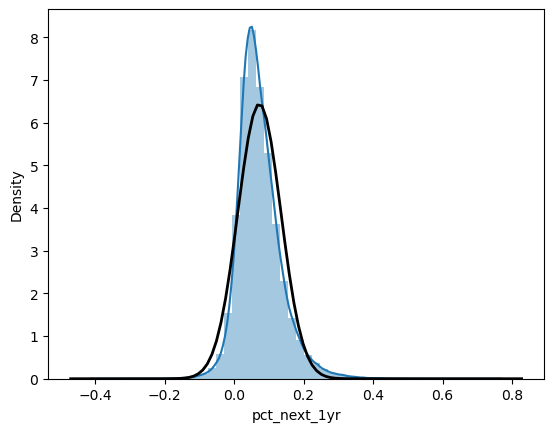

In [24]:
# look at distribution
sns.distplot(dfz4['pct_next_1yr'])
# add normal distribution overlay
mu, std = dfz4['pct_next_1yr'].mean(), dfz4['pct_next_1yr'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
print("Skewness: %f" % dfz4['pct_next_1yr'].skew())
print('positive skewness means right skewed')
print("Kurtosis: %f" % dfz4['pct_next_1yr'].kurt())
print('normal dist has kurtosis of 3, higher kurt means heavier tails and sharper peak')

## df_fields and df_formulas
* df_fields is OK. Some NaNs in note and descr2, but those are informational -- they are not used.
* df_formulas will be used later to add calculated fields

In [25]:
# df_fields is OK. Some NaNs in note and descr2, but those are informational -- not used.
# df_fields = pd.read_csv(path + 'supervised_fields1.csv')
df_fields.sample(5)

code                    myname  use_as_is  \
27  B01001_026E                    female          0   
7   B11001_001E            num_households          0   
14  B08303_001E  mean_travel_time_to_work          1   
17  B07001_049E     moved_fr_other_county          0   
16  B07001_033E      moved_fr_same_county          0   

                                      note  \
27                   use it for proportion   
7   use it for ave household size (popn/).   
14                               use as is   
17                    divide by population   
16                    divide by population   

                                               descr1  \
27                          Estimate!!Total:!!Female:   
7                                    Estimate!!Total:   
14                                   Estimate!!Total:   
17  Estimate!!Total:!!Moved from different county ...   
16        Estimate!!Total:!!Moved within same county:   

                                               descr2  
27                                         SEX BY AGE  
7             HOUSEHOLD TYPE (INCLUDING LIVING ALONE)  
14                                TRAVEL TIME TO WORK  
17  GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY AGE ...  
16  GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY AGE ...

In [26]:
formulas = [
    ['labor_force_perc', '(dfx.labor_force / dfx.population)', 1, 'labor force perc (0-1)'], 
    ['unemployed_perc', '(dfx.unemployed / dfx.population)', 1, 'labor force perc (0-1)'], 
    ['bach_degr_perc', '(dfx.bachelors_degr / dfx.population)', 1, 'bachelors degree perc (0-1)'], 
    ['masters_degr_perc', '(dfx.masters_degr / dfx.population)', 1, 'masters degree perc (0-1)'], 
    ['peops_per_household', '(dfx.population / dfx.num_households)', 1, 'people per household'],
    ['owner_occ_perc', '(dfx.owner_occupied / dfx.num_households)', 1, 'percent owner occupied (0-1)'],
    ['new_units_perc', '(dfx.housing_units_built_last_year / dfx.num_households)', 1, 'units built last year, percent of all units (0-1)'],
    ['families_wU18_perc', '(dfx.families_with_children / dfx.num_households)', 1, 'percent of households with kids under 18 (0-1)'],
    ['poverty_perc', '(dfx.below_poverty_level / dfx.population)', 1, 'percent below poverty level (0-1)'],
    ['non_families_perc', '(dfx.non_family_households / dfx.num_households)', 1, 'percent of non-family households (0-1)'],
    ['vacant_perc', '(dfx.vacant_units / dfx.num_households)', 1, 'percent of units that are vacant (0-1)'],
    ['perc_moved_fr_same_county', '(dfx.moved_fr_same_county / dfx.population)', 1, 'percent moved from within county (0-1)'],
    ['perc_moved_fr_other_county', '(dfx.moved_fr_other_county / dfx.population)', 1, 'percent moved from other county within state (0-1)'],
    ['perc_moved_fr_other_state', '(dfx.moved_fr_other_state / dfx.population)', 1, 'percent moved from other state (0-1)'],
    ['perc_moved_fr_abroad', '(dfx.moved_fr_abroad / dfx.population)', 1, 'percent moved from abroad (0-1)'],
    ['single_fam_perc', '(dfx.single_family_units / dfx.num_households)', 1, 'percent of units that are single family (0-1)'],
    ['public_trans_perc', '(dfx.workers_using_public_trans / dfx.workers)', 1, 'percent of workers using public trans (0-1)'],
    ['foreign_born_perc', '(dfx.foreign_born / dfx.population)', 1, 'foreign born percent (0-1)'], 
    ['male_perc', '(dfx.male / (dfx.male + dfx.female))', 1, 'male percent (M/(M+F)) (0-1)'], 
]
df_formulas = pd.DataFrame(formulas, columns=['myname', 'formula', 'use_as_is', 'note'])
df_formulas

myname  \
0             labor_force_perc   
1              unemployed_perc   
2               bach_degr_perc   
3            masters_degr_perc   
4          peops_per_household   
5               owner_occ_perc   
6               new_units_perc   
7           families_wU18_perc   
8                 poverty_perc   
9            non_families_perc   
10                 vacant_perc   
11   perc_moved_fr_same_county   
12  perc_moved_fr_other_county   
13   perc_moved_fr_other_state   
14        perc_moved_fr_abroad   
15             single_fam_perc   
16           public_trans_perc   
17           foreign_born_perc   
18                   male_perc   

                                              formula  use_as_is  \
0                  (dfx.labor_force / dfx.population)          1   
1                   (dfx.unemployed / dfx.population)          1   
2               (dfx.bachelors_degr / dfx.population)          1   
3                 (dfx.masters_degr / dfx.population)          1   
4               (dfx.population / dfx.num_households)          1   
5           (dfx.owner_occupied / dfx.num_households)          1   
6   (dfx.housing_units_built_last_year / dfx.num_h...          1   
7   (dfx.families_with_children / dfx.num_households)          1   
8          (dfx.below_poverty_level / dfx.population)          1   
9    (dfx.non_family_households / dfx.num_households)          1   
10            (dfx.vacant_units / dfx.num_households)          1   
11        (dfx.moved_fr_same_county / dfx.population)          1   
12       (dfx.moved_fr_other_county / dfx.population)          1   
13        (dfx.moved_fr_other_state / dfx.population)          1   
14             (dfx.moved_fr_abroad / dfx.population)          1   
15     (dfx.single_family_units / dfx.num_households)          1   
16     (dfx.workers_using_public_trans / dfx.workers)          1   
17                (dfx.foreign_born / dfx.population)          1   
18               (dfx.male / (dfx.male + dfx.female))          1   

                                                 note  
0                              labor force perc (0-1)  
1                              labor force perc (0-1)  
2                         bachelors degree perc (0-1)  
3                           masters degree perc (0-1)  
4                                people per household  
5                        percent owner occupied (0-1)  
6   units built last year, percent of all units (0-1)  
7      percent of households with kids under 18 (0-1)  
8                   percent below poverty level (0-1)  
9              percent of non-family households (0-1)  
10             percent of units that are vacant (0-1)  
11             percent moved from within county (0-1)  
12  percent moved from other county within state (...  
13               percent moved from other state (0-1)  
14                    percent moved from abroad (0-1)  
15      percent of units that are single family (0-1)  
16        percent of workers using public trans (0-1)  
17                         foreign born percent (0-1)  
18                       male percent (M/(M+F)) (0-1)

## df_census
* look at nulls, mins, max. Distributions and versus dependent variable will be done later.
* Watch out for thesefields: they are denominators: population, num_households, workers, male + female

In [29]:
# df_census = pd.read_csv(path + 'supervised_census1.csv')
# df_census = df_census.apply(pd.to_numeric)
df_census=dfraw.copy()

In [30]:
flds = df_census.describe().T
flds['nulls']=len(df_census)-flds['count']
flds

count          mean           std  \
zipcode                        331854.0  4.966953e+04  2.756266e+04   
year                           331854.0  2.016509e+03  2.876386e+00   
population                     331854.0  9.731664e+03  1.439819e+04   
median_household_income        330856.0 -3.730369e+07  1.533415e+08   
median_age                     331854.0 -1.139654e+07  8.641678e+07   
labor_force                    331819.0  4.918726e+03  7.473287e+03   
unemployed                     331819.0  3.563450e+02  6.366639e+02   
bachelors_degr                 331854.0  1.249047e+03  2.231157e+03   
masters_degr                   331854.0  5.430742e+02  1.058649e+03   
num_households                 331854.0  3.614666e+03  5.213188e+03   
median_rent                    331406.0 -1.176455e+08  2.541467e+08   
owner_occupied                 331854.0  2.325801e+03  3.219425e+03   
housing_units_built_last_year  331854.0  4.513595e+01  1.778969e+02   
families_with_children         331854.0  1.150304e+03  1.794317e+03   
below_poverty_level            331819.0  4.207944e+02  9.330112e+02   
non_family_households          331854.0  1.232989e+03  1.989294e+03   
mean_travel_time_to_work       331819.0  4.223234e+03  6.416081e+03   
vacant_units                   331854.0  5.032975e+02  8.529327e+02   
moved_fr_same_county           330508.0  8.048042e+02  1.454514e+03   
moved_fr_other_county          330508.0  3.063966e+02  5.817511e+02   
moved_fr_other_state           330508.0  2.198130e+02  4.616873e+02   
moved_fr_abroad                330508.0  5.883539e+01  1.649107e+02   
median_value                   331023.0 -4.365937e+07  1.652812e+08   
ave_num_rooms                  331854.0 -1.943826e+07  1.121652e+08   
single_family_units            331854.0  2.541784e+03  3.470494e+03   
workers_using_public_trans     331819.0  2.186572e+02  1.250945e+03   
workers                        331819.0  4.464378e+03  6.785229e+03   
foreign_born                   331854.0  1.282459e+03  3.685444e+03   
male                           331854.0  4.790448e+03  7.053345e+03   
female                         331854.0  4.941217e+03  7.364656e+03   
gini                           331819.0 -1.893000e+07  1.107325e+08   
cost_of_living_perc            331819.0 -3.197324e+07  1.424545e+08   
median_RE_tax                  329540.0 -4.861531e+07  1.733440e+08   
state                          264960.0  2.989254e+01  1.545692e+01   

                                       min         25%          50%  \
zipcode                              601.0  26651.0000   49736.0000   
year                                2012.0   2014.0000    2017.0000   
population                             0.0    706.0000    2789.0000   
median_household_income       -666666666.0  39156.0000   50905.0000   
median_age                    -666666666.0     36.4000      41.4000   
labor_force                            0.0    322.0000    1312.0000   
unemployed                             0.0     15.0000      82.0000   
bachelors_degr                         0.0     50.0000     225.0000   
masters_degr                           0.0     15.0000      87.0000   
num_households                         0.0    269.0000    1058.0000   
median_rent                   -666666666.0    523.0000     709.0000   
owner_occupied                         0.0    205.0000     795.0000   
housing_units_built_last_year          0.0      0.0000       0.0000   
families_with_children                 0.0     70.0000     307.0000   
below_poverty_level                    0.0     11.0000      80.0000   
non_family_households                  0.0     80.0000     314.0000   
mean_travel_time_to_work               0.0    272.0000    1129.0000   
vacant_units                           0.0     57.0000     199.0000   
moved_fr_same_county                   0.0     21.0000     137.0000   
moved_fr_other_county                  0.0     10.0000      71.0000   
moved_fr_other_state                   0.0      1.0000   

Drop non-sensical rows and drop state column (a better state column is in zillow)

In [31]:
print('len df_census', len(df_census))
dfc2=df_census.copy()

dropzeros=['population', 'num_households', 'workers']
dfc2 = dfc2[dfc2[dropzeros].ne(0).all(axis=1)]

dfc2.drop(dfc2[(dfc2.male + dfc2.female) == 0].index, inplace=True)

drop66 = ['median_household_income', 'median_age', 'median_rent', 'median_value', 'ave_num_rooms', 'gini', 'cost_of_living_perc', 'median_RE_tax']
dfc2 = dfc2[dfc2[drop66].ne(-666666666).all(axis=1)]

dfc2 = dfc2.drop(['state'], axis=1)

print('len dfc2', len(dfc2))


len df_census 331854
len dfc2 266825


In [32]:
flds = dfc2.describe().T
flds['nulls']=len(dfc2)-flds['count']
flds

count           mean            std  \
zipcode                        266825.0   49201.604179   27386.888575   
year                           266825.0    2016.412799       2.871348   
population                     266825.0   11955.791178   15233.535077   
median_household_income        266676.0   57492.623933   24198.358679   
median_age                     266825.0      41.502170       7.197268   
labor_force                    266816.0    6049.337993    7923.485952   
unemployed                     266816.0     438.443009     684.586132   
bachelors_degr                 266825.0    1541.283864    2397.536159   
masters_degr                   266825.0     670.168511    1144.275462   
num_households                 266825.0    4451.316597    5494.248047   
median_rent                    266393.0     872.523137     367.890231   
owner_occupied                 266825.0    2860.218585    3378.768029   
housing_units_built_last_year  266825.0      55.404835     196.708046   
families_with_children         266825.0    1416.994963    1906.383447   
below_poverty_level            266816.0     518.051631    1015.606944   
non_family_households          266825.0    1520.291637    2120.103819   
mean_travel_time_to_work       266816.0    5196.409424    6801.557167   
vacant_units                   266825.0     606.684411     917.280898   
moved_fr_same_county           265692.0     993.246202    1564.016233   
moved_fr_other_county          265692.0     371.891653     622.812628   
moved_fr_other_state           265692.0     261.715279     473.658373   
moved_fr_abroad                265692.0      71.277253     178.873470   
median_value                   266621.0  193254.330765  170682.512953   
ave_num_rooms                  266825.0       5.712751       0.816654   
single_family_units            266825.0    3116.070964    3642.115280   
workers_using_public_trans     266816.0     270.574643    1388.770321   
workers                        266816.0    5490.606051    7193.706498   
foreign_born                   266825.0    1588.114599    4050.724066   
male                           266825.0    5878.992051    7459.981217   
female                         266825.0    6076.799127    7795.237229   
gini                           266816.0       0.422656       0.058691   
cost_of_living_perc            266816.0      18.122613       4.014585   
median_RE_tax                  265662.0    2199.545912    1954.368005   

                                     min         25%          50%  \
zipcode                         601.0000  27542.0000   49331.0000   
year                           2012.0000   2014.0000    2016.0000   
population                       25.0000   1487.0000    4836.0000   
median_household_income        2499.0000  41875.0000   52424.0000   
median_age                        8.9000     36.8000      41.2000   
labor_force                       7.0000    696.0000    2295.0000   
unemployed                        0.0000     37.0000     145.0000   
bachelors_degr                    0.0000    112.0000     415.0000   
masters_degr                      0.0000     38.0000     163.0000   
num_households                   13.0000    582.0000    1834.0000   
median_rent                      99.0000    632.0000     774.0000   
owner_occupied                    5.0000    451.0000    1346.0000   
housing_units_built_last_year     0.0000      0.0000       4.0000   
families_with_children            0.0000    161.0000     542.0000   
below_poverty_level               0.0000     34.0000     137.0000   
non_family_households             0.0000    174.0000     539.0000   
mean_travel_time_to_work          0.0000    595.0000    1980.0000   
vacant_units                      0.0000    102.0000     296.0000   
moved_fr_same_county              0.0000     58.0000     260.0000   
moved_fr_other_county             0.0000     29.0000     123.0000   
moved_fr_other_state              0.0000     10.0000      63.0000   
moved_fr_abroad                  

In [33]:
# nine rows seem to be a problem: they are null for many columns
dropnulls=['labor_force', 'unemployed', 'below_poverty_level', 'mean_travel_time_to_work', 'workers_using_public_trans', 'workers', 'gini', 'cost_of_living_perc']
dfc2 = dfc2.dropna(subset=dropnulls)
print('len dfc2', len(dfc2))

len dfc2 266816


In [34]:
# set some nulls to average
setave = ['median_rent', 'median_household_income', 'median_value', 'median_RE_tax']
for col in setave:
    dfc2[col].fillna(dfc2[col].mean(), inplace=True)

In [35]:
flds = dfc2.describe().T
flds['nulls']=len(dfc2)-flds['count']
flds

count           mean            std  \
zipcode                        266816.0   49200.315116   27386.451022   
year                           266816.0    2016.412745       2.871381   
population                     266816.0   11956.050747   15233.694609   
median_household_income        266816.0   57492.623933   24192.009308   
median_age                     266816.0      41.502261       7.197170   
labor_force                    266816.0    6049.337993    7923.485952   
unemployed                     266816.0     438.443009     684.586132   
bachelors_degr                 266816.0    1541.326577    2397.563779   
masters_degr                   266816.0     670.186327    1144.289931   
num_households                 266816.0    4451.422388    5494.299955   
median_rent                    266816.0     872.529874     367.595602   
owner_occupied                 266816.0    2860.283581    3378.798960   
housing_units_built_last_year  266816.0      55.406317     196.711176   
families_with_children         266816.0    1417.029189    1906.404288   
below_poverty_level            266816.0     518.051631    1015.606944   
non_family_households          266816.0    1520.326045    2120.126660   
mean_travel_time_to_work       266816.0    5196.409424    6801.557167   
vacant_units                   266816.0     606.684667     917.290284   
moved_fr_same_county           265692.0     993.246202    1564.016233   
moved_fr_other_county          265692.0     371.891653     622.812628   
moved_fr_other_state           265692.0     261.715279     473.658373   
moved_fr_abroad                265692.0      71.277253     178.873470   
median_value                   266816.0  193256.071831  170619.377898   
ave_num_rooms                  266816.0       5.712778       0.816654   
single_family_units            266816.0    3116.140055    3642.148961   
workers_using_public_trans     266816.0     270.574643    1388.770321   
workers                        266816.0    5490.606051    7193.706498   
foreign_born                   266816.0    1588.161684    4050.783669   
male                           266816.0    5879.119086    7460.058960   
female                         266816.0    6076.931661    7795.319462   
gini                           266816.0       0.422656       0.058691   
cost_of_living_perc            266816.0      18.122613       4.014585   
median_RE_tax                  266816.0    2199.598288    1950.115878   

                                     min         25%          50%  \
zipcode                         601.0000  27541.0000   49331.0000   
year                           2012.0000   2014.0000    2016.0000   
population                       25.0000   1487.0000    4836.0000   
median_household_income        2499.0000  41875.0000   52436.0000   
median_age                        8.9000     36.8000      41.2000   
labor_force                       7.0000    696.0000    2295.0000   
unemployed                        0.0000     37.0000     145.0000   
bachelors_degr                    0.0000    112.0000     415.0000   
masters_degr                      0.0000     38.0000     163.0000   
num_households                   13.0000    582.0000    1834.0000   
median_rent                      99.0000    633.0000     775.0000   
owner_occupied                    5.0000    450.7500    1346.0000   
housing_units_built_last_year     0.0000      0.0000       4.0000   
families_with_children            0.0000    161.0000     542.0000   
below_poverty_level               0.0000     34.0000     137.0000   
non_family_households             0.0000    174.0000     539.0000   
mean_travel_time_to_work          0.0000    595.0000    1980.0000   
vacant_units                      0.0000    102.0000     296.0000   
moved_fr_same_county              0.0000     58.0000     260.0000   
moved_fr_other_county             0.0000     29.0000     123.0000   
moved_fr_other_state              0.0000     10.0000      63.0000   
moved_fr_abroad                  

In [36]:
df_formulas

myname  \
0             labor_force_perc   
1              unemployed_perc   
2               bach_degr_perc   
3            masters_degr_perc   
4          peops_per_household   
5               owner_occ_perc   
6               new_units_perc   
7           families_wU18_perc   
8                 poverty_perc   
9            non_families_perc   
10                 vacant_perc   
11   perc_moved_fr_same_county   
12  perc_moved_fr_other_county   
13   perc_moved_fr_other_state   
14        perc_moved_fr_abroad   
15             single_fam_perc   
16           public_trans_perc   
17           foreign_born_perc   
18                   male_perc   

                                              formula  use_as_is  \
0                  (dfx.labor_force / dfx.population)          1   
1                   (dfx.unemployed / dfx.population)          1   
2               (dfx.bachelors_degr / dfx.population)          1   
3                 (dfx.masters_degr / dfx.population)          1   
4               (dfx.population / dfx.num_households)          1   
5           (dfx.owner_occupied / dfx.num_households)          1   
6   (dfx.housing_units_built_last_year / dfx.num_h...          1   
7   (dfx.families_with_children / dfx.num_households)          1   
8          (dfx.below_poverty_level / dfx.population)          1   
9    (dfx.non_family_households / dfx.num_households)          1   
10            (dfx.vacant_units / dfx.num_households)          1   
11        (dfx.moved_fr_same_county / dfx.population)          1   
12       (dfx.moved_fr_other_county / dfx.population)          1   
13        (dfx.moved_fr_other_state / dfx.population)          1   
14             (dfx.moved_fr_abroad / dfx.population)          1   
15     (dfx.single_family_units / dfx.num_households)          1   
16     (dfx.workers_using_public_trans / dfx.workers)          1   
17                (dfx.foreign_born / dfx.population)          1   
18               (dfx.male / (dfx.male + dfx.female))          1   

                                                 note  
0                              labor force perc (0-1)  
1                              labor force perc (0-1)  
2                         bachelors degree perc (0-1)  
3                           masters degree perc (0-1)  
4                                people per household  
5                        percent owner occupied (0-1)  
6   units built last year, percent of all units (0-1)  
7      percent of households with kids under 18 (0-1)  
8                   percent below poverty level (0-1)  
9              percent of non-family households (0-1)  
10             percent of units that are vacant (0-1)  
11             percent moved from within county (0-1)  
12  percent moved from other county within state (...  
13               percent moved from other state (0-1)  
14                    percent moved from abroad (0-1)  
15      percent of units that are single family (0-1)  
16        percent of workers using public trans (0-1)  
17                         foreign born percent (0-1)  
18                       male percent (M/(M+F)) (0-1)

## calculated census columns

In [37]:
# do the calculated fields
dfx = dfc2
for newcol, formula, ignore1, ignore2 in formulas:
    # print(newcol + ' = ' + formula)
    dfx = pd.eval(newcol + ' = ' + formula, target = dfx)

dfx.head()

zipcode  year  population  median_household_income  median_age  \
0     2655  2012        3846                  73323.0        54.6   
1     2657  2012        2974                  46031.0        52.9   
2     2659  2012         741                  51466.0        61.0   
3     2660  2012        5881                  48617.0        51.3   
5     2664  2012        9562                  49698.0        50.3   

   labor_force  unemployed  bachelors_degr  masters_degr  num_households  ...  \
0       1626.0       156.0             732           399            1699  ...   
1       1992.0       258.0             883           422            1687  ...   
2        355.0        31.0             121            62             374  ...   
3       2835.0       173.0             976           419            2699  ...   
5       4899.0       425.0            1398           656            4634  ...   

   non_families_perc  vacant_perc  perc_moved_fr_same_county  \
0           0.314303     0.794585                   0.060322   
1           0.763485     1.643154                   0.035642   
2           0.368984     2.278075                   0.000000   
3           0.400519     0.588737                   0.049141   
5           0.447777     0.510358                   0.045179   

   perc_moved_fr_other_county  perc_moved_fr_other_state  \
0                    0.010400                   0.015601   
1                    0.015804                   0.037996   
2                    0.000000                   0.066127   
3                    0.014963                   0.011733   
5                    0.017151                   0.046434   

   perc_moved_fr_abroad  single_fam_perc  public_trans_perc  \
0              0.000000         1.656268           0.017100   
1              0.004707         1.133966           0.025309   
2              0.000000         3.160428           0.047319   
3              0.000000         1.288625           0.016575   
5              0.001255         1.232197           0.028906   

   foreign_born_perc  male_perc  
0           0.083983   0.447998  
1           0.079354   0.575656  
2           0.116059   0.464238  
3           0.035368   0.477300  
5           0.104685   0.453880  

[5 rows x 52 columns]

In [38]:
# drop cols used in calc but not needed for models 
cols_to_drop = df_fields[df_fields['use_as_is']==0]['myname'].tolist()
dfx.drop(columns=cols_to_drop, inplace=True)

In [39]:
flds = dfx.describe().T
flds['nulls']=len(dfx)-flds['count']
flds

count           mean            std  \
zipcode                     266816.0   49200.315116   27386.451022   
year                        266816.0    2016.412745       2.871381   
population                  266816.0   11956.050747   15233.694609   
median_household_income     266816.0   57492.623933   24192.009308   
median_age                  266816.0      41.502261       7.197170   
median_rent                 266816.0     872.529874     367.595602   
mean_travel_time_to_work    266816.0    5196.409424    6801.557167   
median_value                266816.0  193256.071831  170619.377898   
ave_num_rooms               266816.0       5.712778       0.816654   
gini                        266816.0       0.422656       0.058691   
cost_of_living_perc         266816.0      18.122613       4.014585   
median_RE_tax               266816.0    2199.598288    1950.115878   
labor_force_perc            266816.0       0.489329       0.077782   
unemployed_perc             266816.0       0.033463       0.021639   
bach_degr_perc              266816.0       0.107916       0.063629   
masters_degr_perc           266816.0       0.045149       0.037362   
peops_per_household         266816.0       2.633102       0.521058   
owner_occ_perc              266816.0       0.722589       0.151225   
new_units_perc              266816.0       0.010660       0.024077   
families_wU18_perc          266816.0       0.302986       0.092512   
poverty_perc                266816.0       0.040527       0.037884   
non_families_perc           266816.0       0.323941       0.103368   
vacant_perc                 266816.0       0.241495       0.438238   
perc_moved_fr_same_county   265692.0       0.065793       0.044868   
perc_moved_fr_other_county  265692.0       0.032378       0.031080   
perc_moved_fr_other_state   265692.0       0.019190       0.022822   
perc_moved_fr_abroad        265692.0       0.003598       0.007615   
single_fam_perc             266816.0       0.887279       0.396503   
public_trans_perc           266816.0       0.020793       0.060849   
foreign_born_perc           266816.0       0.066708       0.094544   
male_perc                   266816.0       0.498590       0.038174   

                                    min           25%            50%  \
zipcode                      601.000000  27541.000000   49331.000000   
year                        2012.000000   2014.000000    2016.000000   
population                    25.000000   1487.000000    4836.000000   
median_household_income     2499.000000  41875.000000   52436.000000   
median_age                     8.900000     36.800000      41.200000   
median_rent                   99.000000    633.000000     775.000000   
mean_travel_time_to_work       0.000000    595.000000    1980.000000   
median_value                9999.000000  95400.000000  143100.000000   
ave_num_rooms                  1.300000      5.300000       5.700000   
gini                           0.091900      0.384800       0.419100   
cost_of_living_perc            9.000000     15.500000      17.800000   
median_RE_tax                199.000000    910.000000    1532.000000   
labor_force_perc               0.026502      0.444000       0.495696   
unemployed_perc                0.000000      0.019048       0.029770   
bach_degr_perc                 0.000000      0.062069       0.093193   
masters_degr_perc              0.000000      0.020100       0.034192   
peops_per_household            1.041667      2.375549       2.574286   
owner_occ_perc                 0.004472      0.656549       0.754386   
new_units_perc                 0.000000      0.000000       0.001464   
families_wU18_perc             0.000000      0.248000       0.300941   
poverty_perc                   0.000000      0.013524       0.030757   
non_families_perc              0.000000      0.257462       0.314794   
vacant_perc                    0.000000      0.075899       0.138462   
perc_moved_fr_same_county      0.000000      0.034092       0.

In [40]:
# fix the remaining nulls
setave = ['perc_moved_fr_same_county', 'perc_moved_fr_other_county', 'perc_moved_fr_other_state', 'perc_moved_fr_abroad']
for col in setave:
    dfx[col].fillna(dfx[col].mean(), inplace=True)

## combine census and zillow, save df_combo

In [41]:
merged_x = dfx.merge(dfz4, on=['zipcode', 'year'], how='left', indicator=True)
not_in_dfz4 = merged_x[merged_x['_merge'] == 'left_only']
print(len(dfx), len(dfz4), len(not_in_dfz4))
not_in_dfz4['population'].describe()   # 75% of these have populations less than 591

266816 231267 49492


count     49492.000000
mean       2135.748586
std        5926.984166
min          25.000000
25%         419.000000
50%         784.000000
75%        1523.000000
max      108427.000000
Name: population, dtype: float64

In [42]:
merged_z = dfz4.merge(dfx, on=['zipcode', 'year'], how='left', indicator=True)
not_in_dfx = merged_z[merged_z['_merge'] == 'left_only']
print(len(dfx), len(dfz4), len(not_in_dfx))
# not_in_dfx.sample(20)
not2 = not_in_dfx.loc[not_in_dfx['year']!=2022]
print(len(dfx), len(dfz4), len(not_in_dfx), len(not2))
not2.sample(20)
# not_in_dfx['population'].max()   # 108k
# not_in_dfx['population'].describe()

266816 231267 13943
266816 231267 13943 13943


zipcode state         city  \
12176      6060    CT       Granby   
100370    41214    KY   Boons Camp   
148323    59739    MT         Lima   
8141       4085    ME     Standish   
2935       2071    MA      Walpole   
60969     26817    WV     Bloomery   
53268     22732    VA        Aroda   
88877     36258    AL        Delta   
67217     28718    NC      Brevard   
123270    48747    MI          NaN   
219        1037    MA     Hardwick   
196628    80652    CO       Roggen   
166690    67227    KS          NaN   
145499    56657    MN      Marcell   
97006     39478    MS   Sandy Hook   
161749    64873    MO    Wentworth   
102300    42436    KY      Manitou   
134925    53576    WI  Orfordville   
113121    46049    IN      Kempton   
25754     12410    NY   Big Indian   

                                               metro               county  \
12176          Hartford-East Hartford-Middletown, CT      Hartford County   
100370                                           NaN        Martin County   
148323                                           NaN    Beaverhead County   
8141                     Portland-South Portland, ME    Cumberland County   
2935                  Boston-Cambridge-Newton, MA-NH       Norfolk County   
60969                              Winchester, VA-WV     Hampshire County   
53268   Washington-Arlington-Alexandria, DC-VA-MD-WV       Madison County   
88877                                            NaN      Cleburne County   
67217                                    Brevard, NC  Transylvania County   
123270                                  Bay City, MI           Bay County   
219                                 Worcester, MA-CT     Worcester County   
196628                                   Greeley, CO          Weld County   
166690                                   Wichita, KS      Sedgwick County   
145499                              Grand Rapids, MN        Itasca County   
97006                                            NaN      Walthall County   
161749                                           NaN      Lawrence County   
102300                              Madisonville, KY       Hopkins County   
134925                         Janesville-Beloit, WI          Rock County   
113121                                           NaN        Tipton County   
25754                                   Kingston, NY        Ulster County   

        year      typ_price  pct_next_1yr  pct_next_2yr  pct_next_3yr  ...  \
12176   2019  349760.801646      0.072312      0.202801      0.327076  ...   
100370  2020   84180.937190      0.097980      0.290532           NaN  ...   
148323  2013  111807.369559      0.072692      0.088227      0.108586  ...   
8141    2019  247758.664908      0.157951      0.321064      0.508021  ...   
2935    2020  609651.137400      0.101543      0.177333           NaN  ...   
60969   2016  165321.414770      0.027709      0.059229      0.097100  ...   
53268   2012  205443.018051     -0.016144      0.005615      0.041853  ...   
88877   2021  199358.142745      0.000645           NaN           NaN  ...   
67217   2017  196813.943686      0.063177      0.092166      0.272251  ...   
123270  2018  111390.181491      0.152050      0.275131      0.382375  ...   
219     2021  375875.766641      0.109894           NaN           NaN  ...   
196628  2015  303730.218750      0.114778      0.267151      0.332747  ...   
166690  2019  332015.510093      0.074528      0.207104      0.336236  ...   
145499  2014  210279.656733      0.004537      0.006320      0.026126  ...   
97006   2014  111285.855819      0.103245      0.091110      0.051981  ...   
161749  2018  141367.192580      0.034716      0.192153      0.413314  ...   
102300  2018  131837.921927      0.064865      0.125566      0.293358  ...   
134925  2021  230733.923725      0.076120           NaN           NaN  ...   
113121  2019  121663.338749      0.059359      0.307847      0.365946  ...   
25754   2016  216849.141430    

In [43]:
dfcombo = dfx.merge(dfz4, on=['zipcode', 'year'], how='inner')
print(dfcombo.shape)
dfcombo.head()

(217324, 46)


zipcode  year  population  median_household_income  median_age  \
0     2655  2012        3846                  73323.0        54.6   
1     2657  2012        2974                  46031.0        52.9   
2     2659  2012         741                  51466.0        61.0   
3     2660  2012        5881                  48617.0        51.3   
4     2664  2012        9562                  49698.0        50.3   

   median_rent  mean_travel_time_to_work  median_value  ave_num_rooms    gini  \
0       1265.0                    1394.0      443500.0            6.8  0.5339   
1        936.0                    1517.0      467100.0            3.7  0.5349   
2       1208.0                     285.0      469800.0            5.5  0.3777   
3       1055.0                    2469.0      342800.0            5.4  0.4286   
4       1271.0                    4149.0      303800.0            5.1  0.4380   

   ...  pct_next_1yr  pct_next_2yr  pct_next_3yr  pct_next_4yr  pct_next_5yr  \
0  ...      0.051160      0.087641      0.110632      0.164412      0.205938   
1  ...      0.093282      0.240235      0.322248      0.418350      0.558377   
2  ...      0.041903      0.087301      0.152702      0.187533      0.248760   
3  ...      0.052785      0.080764      0.146780      0.200872      0.297018   
4  ...      0.059477      0.086348      0.147343      0.225341      0.287225   

   pct_next_6yr  pct_next_7yr  pct_next_8yr  pct_next_9yr  pct_next_10yr  
0      0.263887      0.296016      0.440883      0.852849       1.068989  
1      0.646149      0.698518      0.809535      1.239531       1.500159  
2      0.293473      0.315354      0.438934      0.789102       1.074293  
3      0.349806      0.392865      0.539608      0.879304       1.089731  
4      0.352833      0.394227      0.548728      0.859606       1.108462  

[5 rows x 46 columns]

In [44]:
dfcombo.to_csv(path + 'supervised_combo.csv', index=False)

In [45]:
dfcombo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217324 entries, 0 to 217323
Data columns (total 46 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   zipcode                     217324 non-null  int64  
 1   year                        217324 non-null  int64  
 2   population                  217324 non-null  int64  
 3   median_household_income     217324 non-null  float64
 4   median_age                  217324 non-null  float64
 5   median_rent                 217324 non-null  float64
 6   mean_travel_time_to_work    217324 non-null  float64
 7   median_value                217324 non-null  float64
 8   ave_num_rooms               217324 non-null  float64
 9   gini                        217324 non-null  float64
 10  cost_of_living_perc         217324 non-null  float64
 11  median_RE_tax               217324 non-null  float64
 12  labor_force_perc            217324 non-null  float64
 13  unemployed_per

In [46]:
flds = dfcombo.describe().T
flds['nulls']=len(dfcombo)-flds['count']
flds

count           mean            std  \
zipcode                     217324.0   48161.549309   27812.434636   
year                        217324.0    2016.619789       2.857517   
population                  217324.0   14192.464555   15809.836341   
median_household_income     217324.0   60253.622380   24950.906483   
median_age                  217324.0      41.236737       6.945752   
median_rent                 217324.0     923.939557     374.824226   
mean_travel_time_to_work    217324.0    6207.458339    7099.169141   
median_value                217324.0  212311.416930  179707.665540   
ave_num_rooms               217324.0       5.731863       0.833573   
gini                        217324.0       0.424868       0.055501   
cost_of_living_perc         217324.0      18.580239       3.757784   
median_RE_tax               217324.0    2450.097165    2034.596415   
labor_force_perc            217324.0       0.495243       0.072232   
unemployed_perc             217324.0       0.033299       0.019219   
bach_degr_perc              217324.0       0.114922       0.064262   
masters_degr_perc           217324.0       0.049631       0.038132   
peops_per_household         217324.0       2.639761       0.451557   
owner_occ_perc              217324.0       0.716066       0.155266   
new_units_perc              217324.0       0.011487       0.024690   
families_wU18_perc          217324.0       0.305486       0.089063   
poverty_perc                217324.0       0.038404       0.034039   
non_families_perc           217324.0       0.324344       0.103213   
vacant_perc                 217324.0       0.222737       0.433072   
perc_moved_fr_same_county   217324.0       0.069024       0.043296   
perc_moved_fr_other_county  217324.0       0.032361       0.028361   
perc_moved_fr_other_state   217324.0       0.019694       0.020843   
perc_moved_fr_abroad        217324.0       0.003966       0.007325   
single_fam_perc             217324.0       0.858715       0.388301   
public_trans_perc           217324.0       0.024090       0.065351   
foreign_born_perc           217324.0       0.075785       0.099201   
male_perc                   217324.0       0.497103       0.033649   
typ_price                   217324.0  234898.367942  221275.942854   
pct_next_1yr                217324.0       0.072615       0.061442   
pct_next_2yr                194646.0       0.151725       0.109241   
pct_next_3yr                172037.0       0.230484       0.150072   
pct_next_4yr                149213.0       0.307696       0.187517   
pct_next_5yr                126723.0       0.395037       0.233296   
pct_next_6yr                104497.0       0.491687       0.283001   
pct_next_7yr                 82436.0       0.600674       0.332725   
pct_next_8yr                 61393.0       0.740510       0.392525   
pct_next_9yr                 40664.0       0.899868       0.475950   
pct_next_10yr                20276.0       1.052452       0.572992   

                                    min            25%            50%  \
zipcode                     1001.000000   25315.000000   47171.000000   
year                        2012.000000    2014.000000    2017.000000   
population                    25.000000    2512.000000    7483.000000   
median_household_income     2499.000000   43789.750000   54638.500000   
median_age                    15.900000      36.700000      40.900000   
median_rent                   99.000000     671.000000     821.000000   
mean_travel_time_to_work       0.000000    1035.000000    3109.000000   
median_value                9999.000000  108500.000000  158200.000000   
ave_num_rooms                  1.300000       5.300000       5.700000   
gini                           0.128000       0.388275       0.420900   
cost_of_living_perc            9.000000      16.100000      18.200000   
median_RE_tax                199.000000    1078.000000    1790.000000   
labor_force_perc               0.028072       0.452407       0.500702  

In [47]:
# dist
def doplots(varname):
    var = dfcombo[varname]
    sns.distplot(var)

    # add normal distribution overlay
    mu, std = var.mean(), var.std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    # print some stats
    print("Skewness: %f" % var.skew())
    print('positive skewness means right skewed')
    print("Kurtosis: %f" % var.kurt())
    print('normal dist has kurtosis of 3, higher kurt means heavier tails and sharper peak')

    # add plot for this var versis independent var
    data = pd.concat([dfcombo['pct_next_1yr'], dfcombo[varname]], axis=1)
    data.plot.scatter(x=varname, y='pct_next_1yr') # , ylim=(0,800000)



In [48]:
# path = '../assets/'
# dfcombo = pd.read_csv(path + 'supervised_combo.csv')
# dfcombo.describe().T

ref: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

At this point, we won't worry about the 2-year gains, 3-year gains...
Don't plot zip codes

## pair plots

In [49]:
fields = dfcombo.columns.tolist()
x = fields
del x[31:]
del x[0:2]
x
y = ['pct_next_1yr']
both = y + x
both

['pct_next_1yr',
 'population',
 'median_household_income',
 'median_age',
 'median_rent',
 'mean_travel_time_to_work',
 'median_value',
 'ave_num_rooms',
 'gini',
 'cost_of_living_perc',
 'median_RE_tax',
 'labor_force_perc',
 'unemployed_perc',
 'bach_degr_perc',
 'masters_degr_perc',
 'peops_per_household',
 'owner_occ_perc',
 'new_units_perc',
 'families_wU18_perc',
 'poverty_perc',
 'non_families_perc',
 'vacant_perc',
 'perc_moved_fr_same_county',
 'perc_moved_fr_other_county',
 'perc_moved_fr_other_state',
 'perc_moved_fr_abroad',
 'single_fam_perc',
 'public_trans_perc',
 'foreign_born_perc',
 'male_perc']

In [50]:
seta = both[0:1] + both[1:7]
setb = both[0:1] + both[7:14]
setc = both[0:1] + both[14:21]
setd = both[0:1] + both[21:27]
sete = both[0:1] + both[27:]

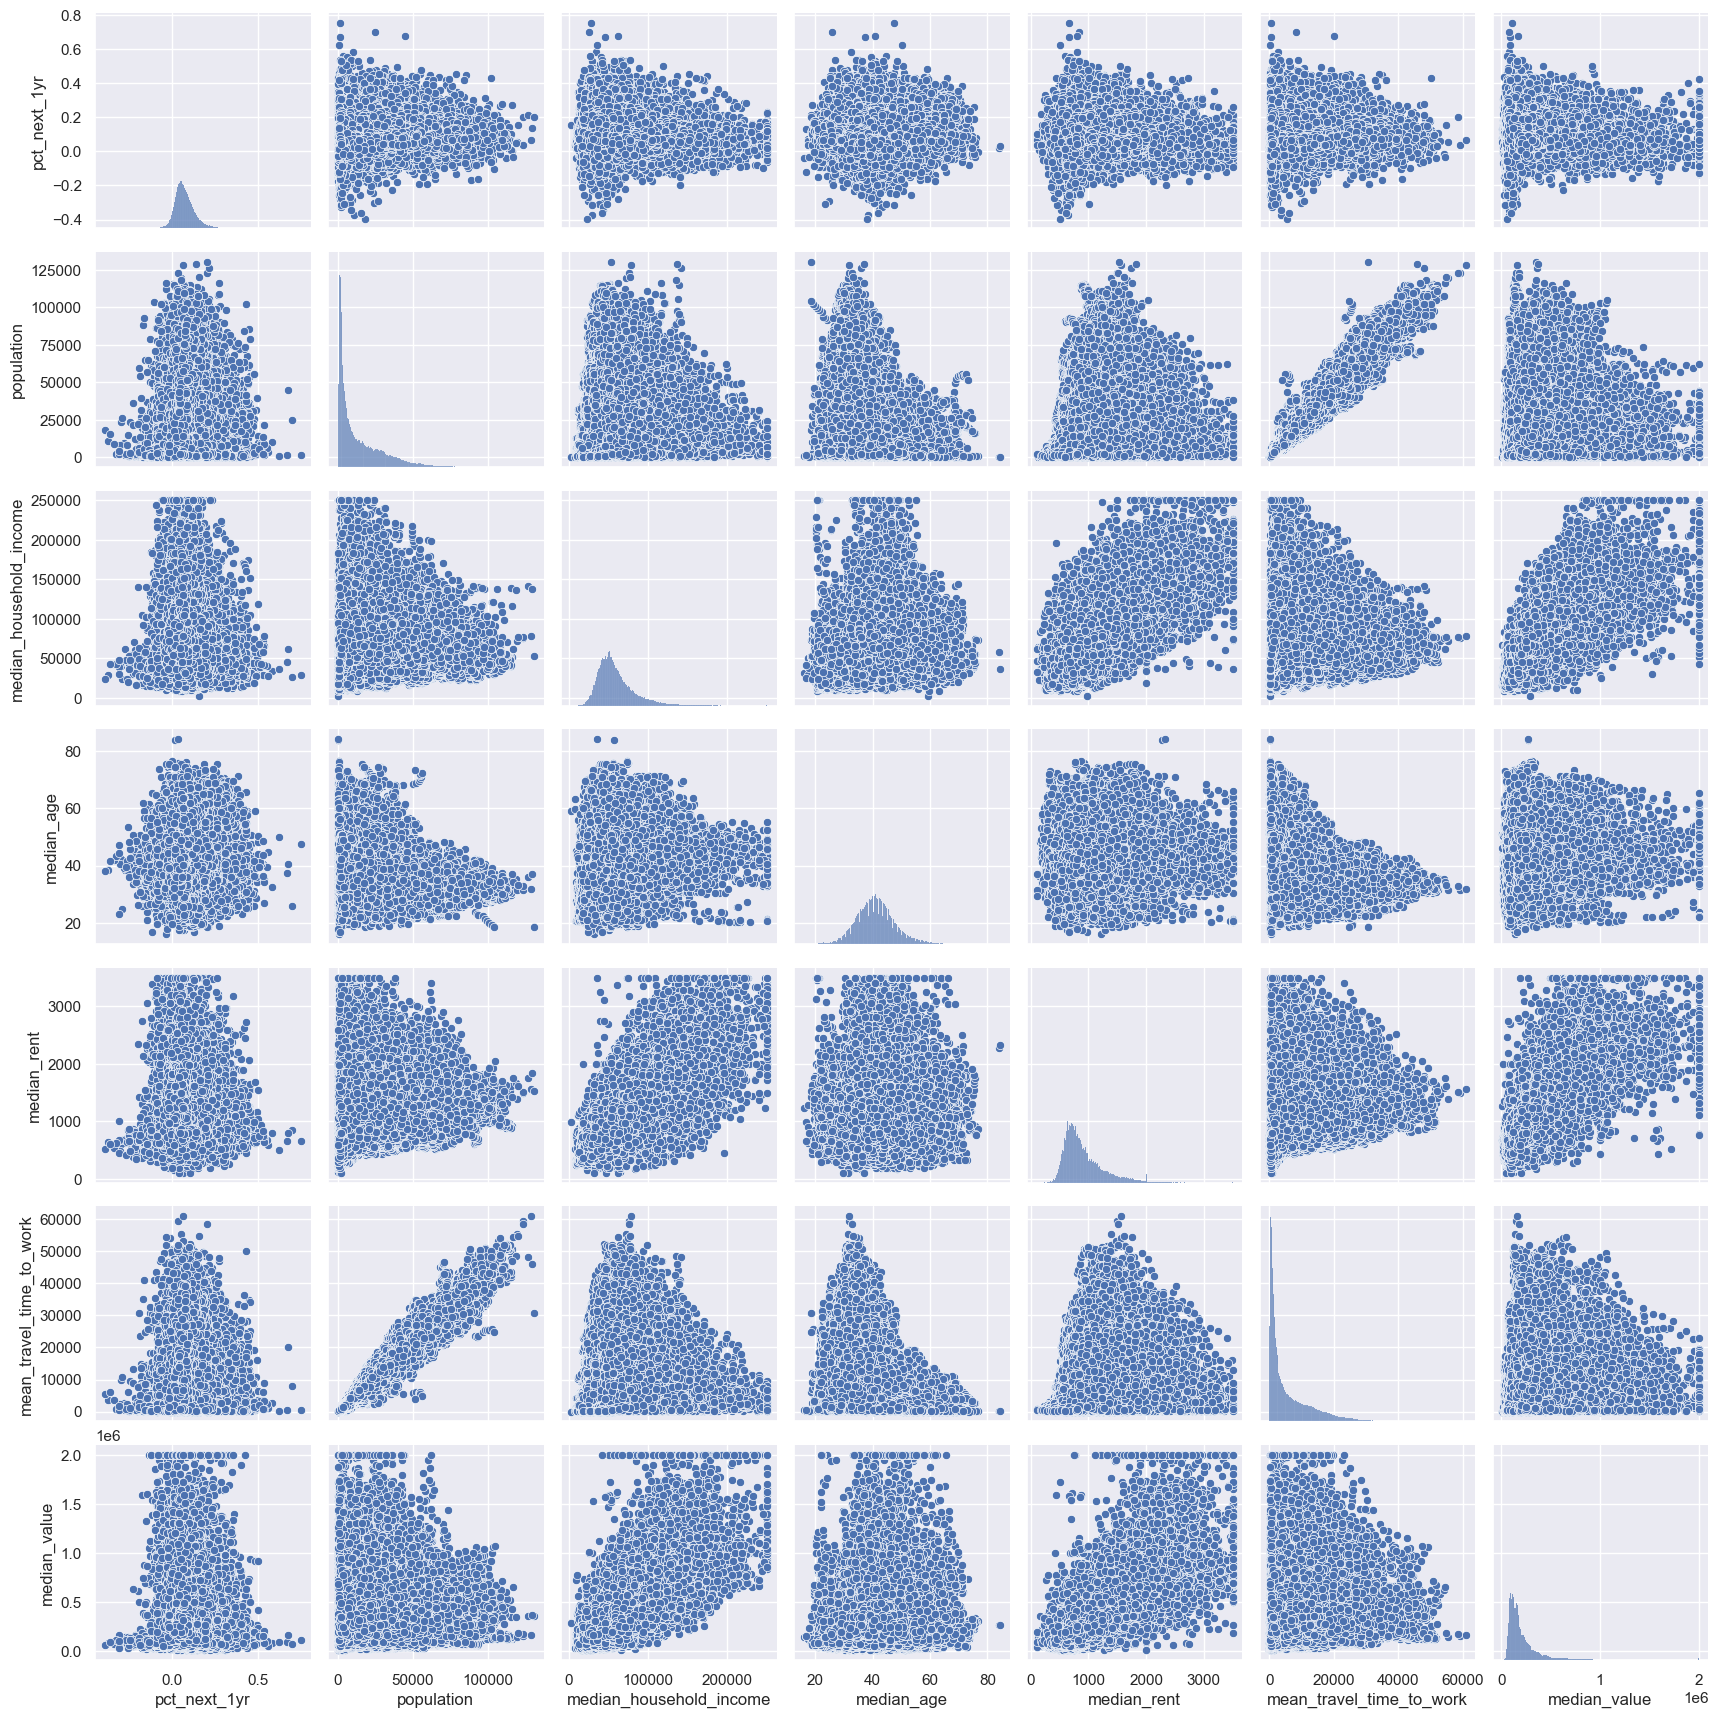

In [51]:
sns.set()
sns.pairplot(dfcombo[seta], height = 2.5)
plt.show()

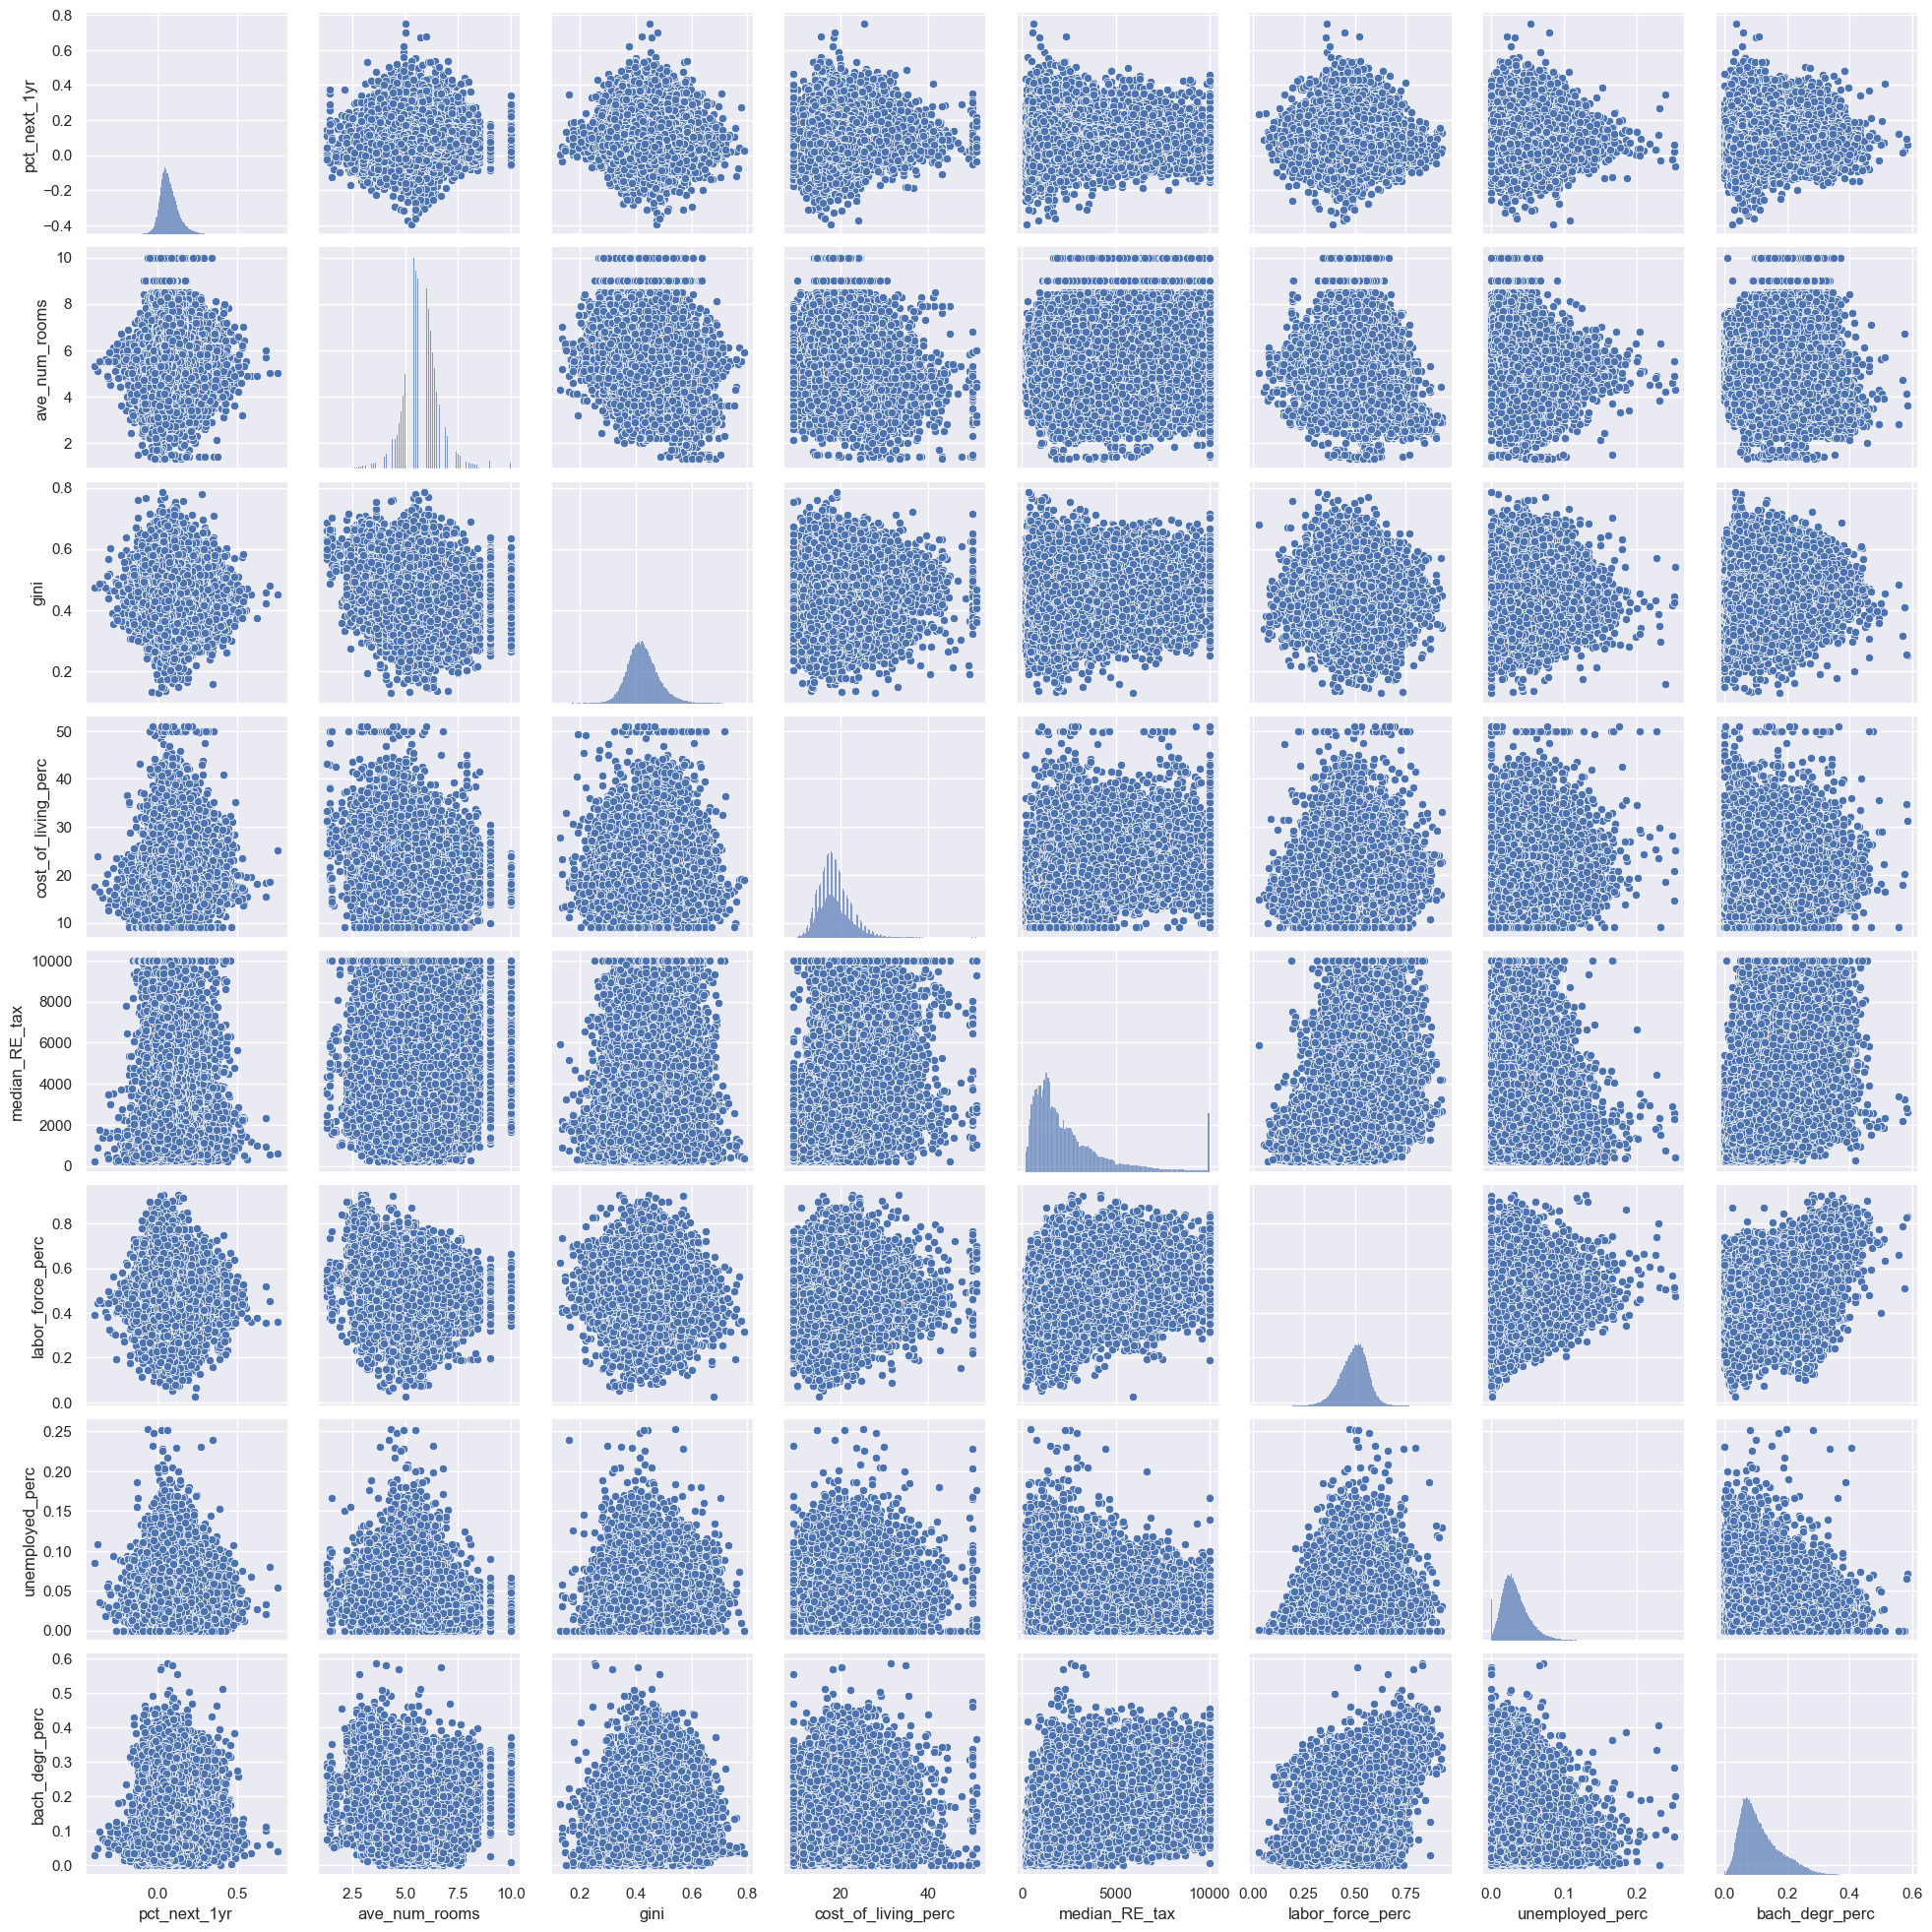

In [52]:
sns.set()
sns.pairplot(dfcombo[setb], height = 2.5)
plt.show()

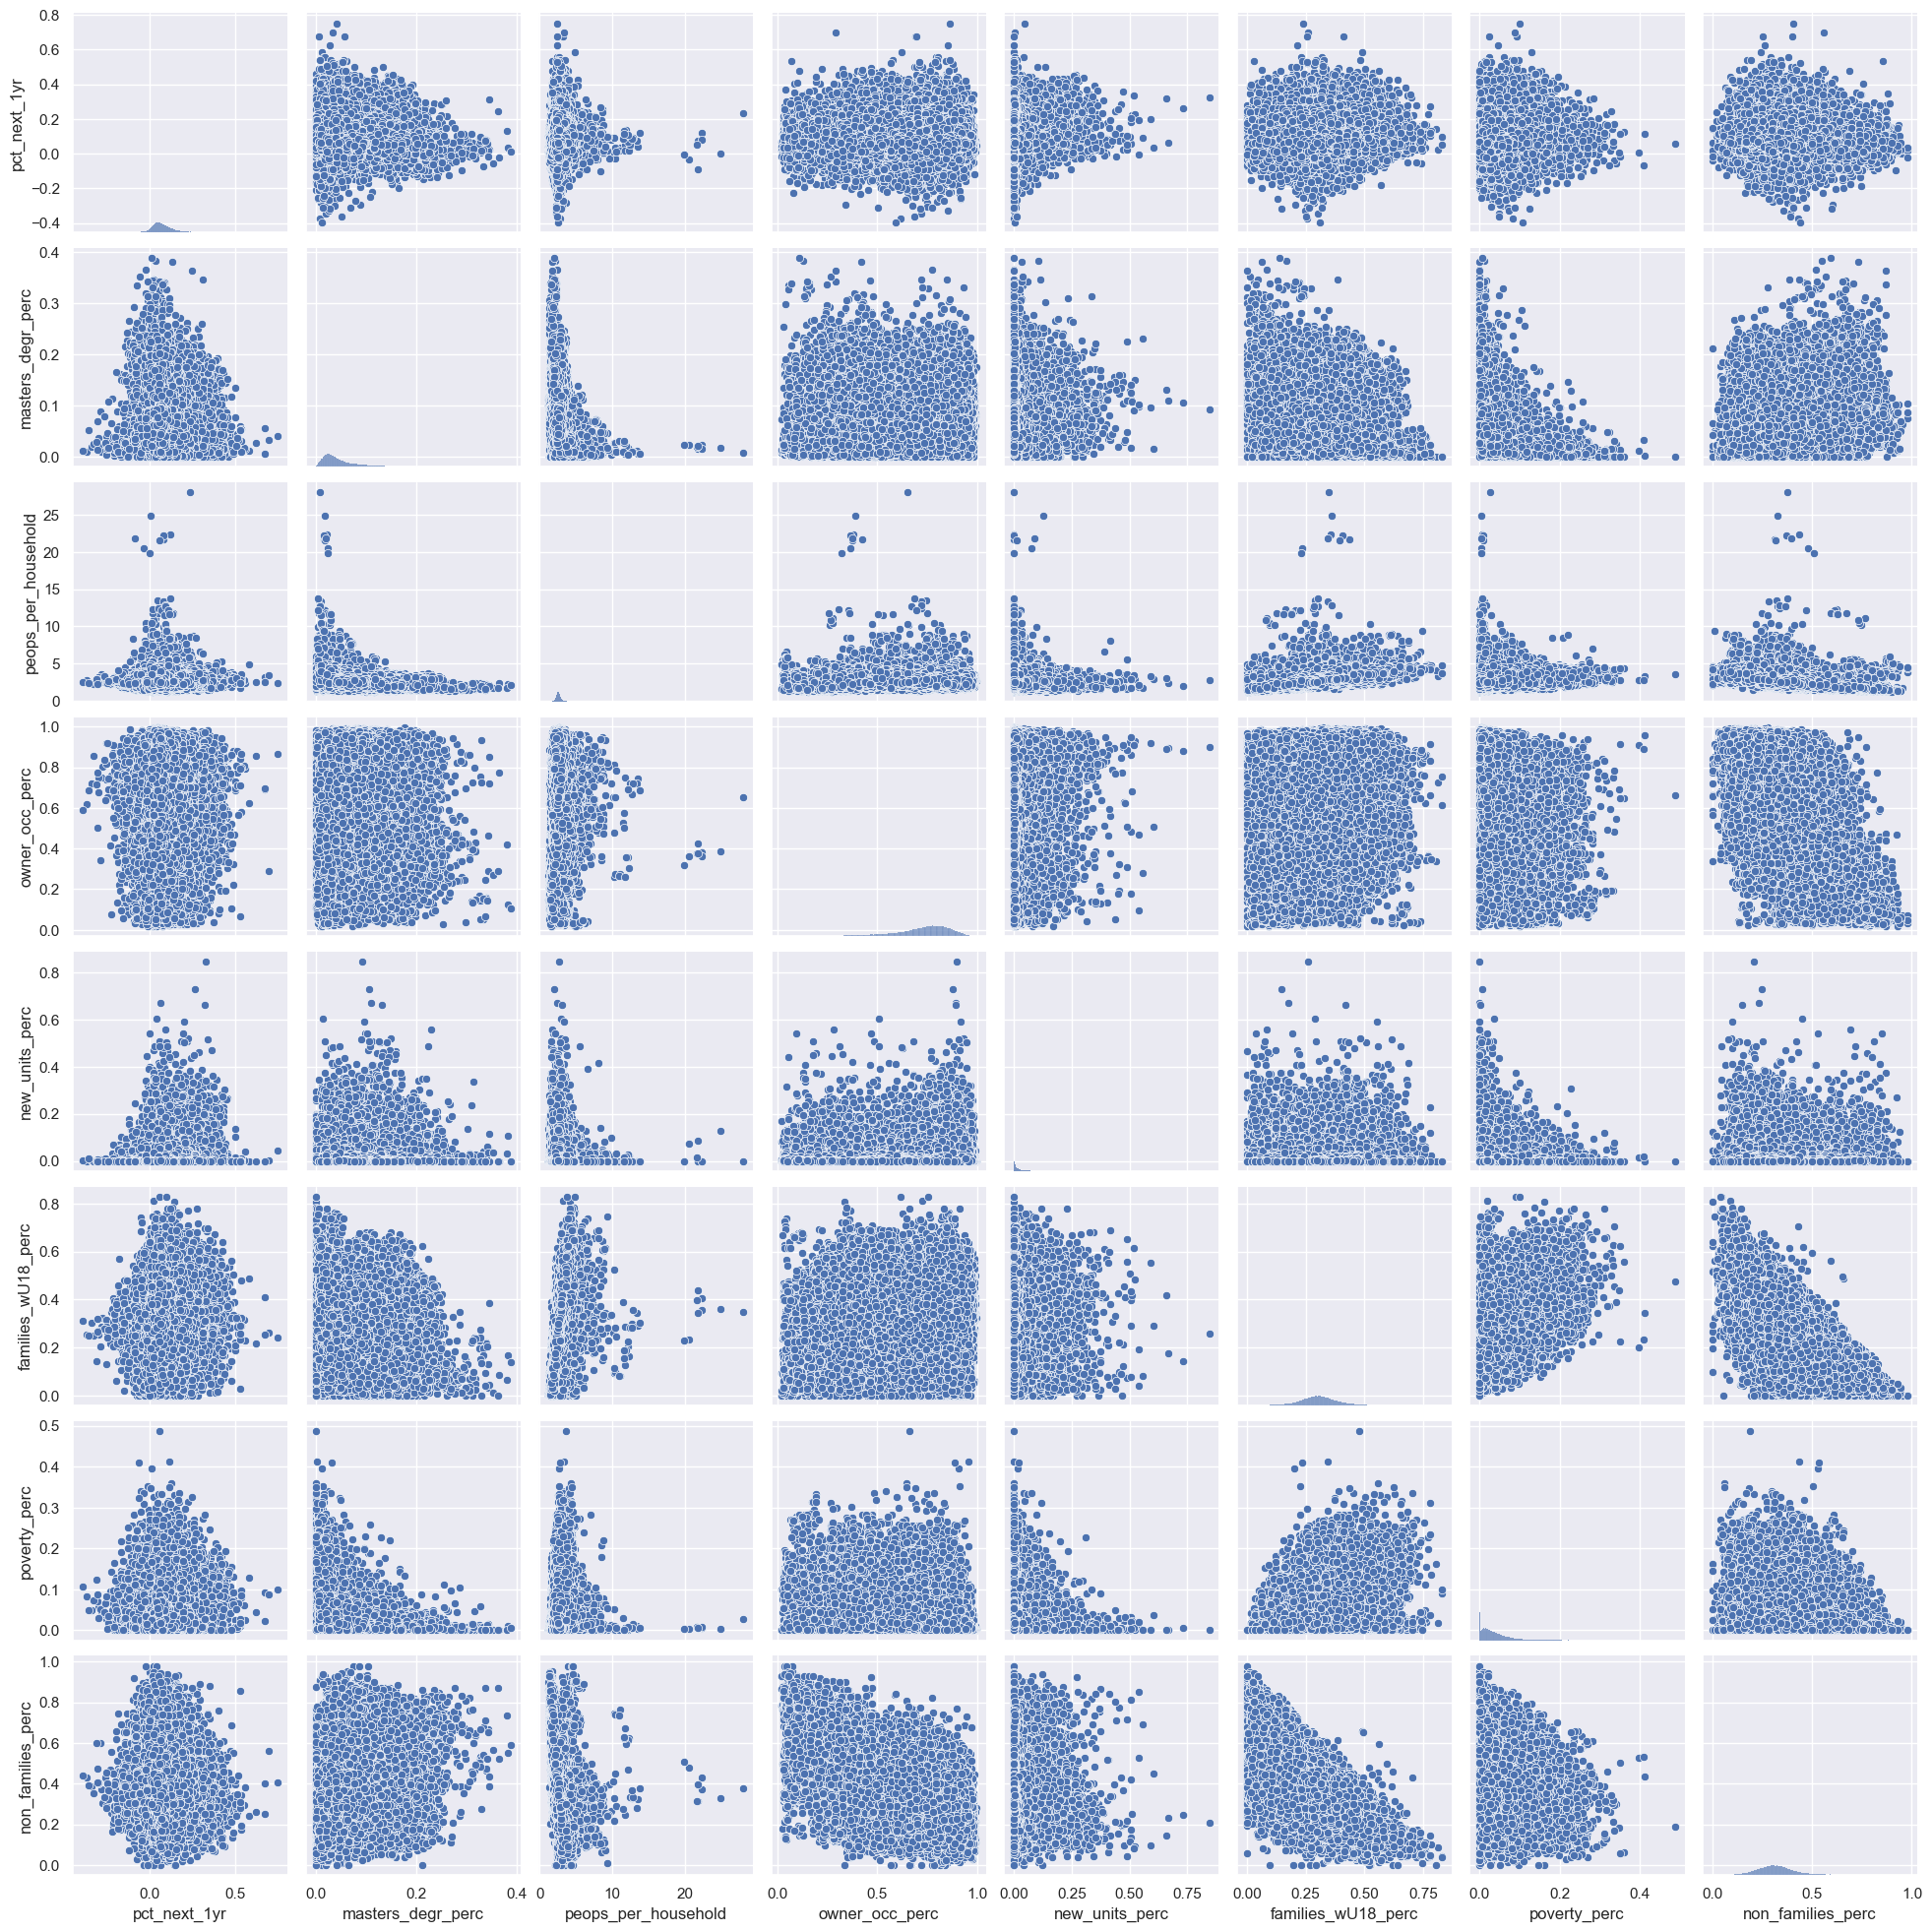

In [53]:
sns.set()
sns.pairplot(dfcombo[setc], height = 2.5)
plt.show()

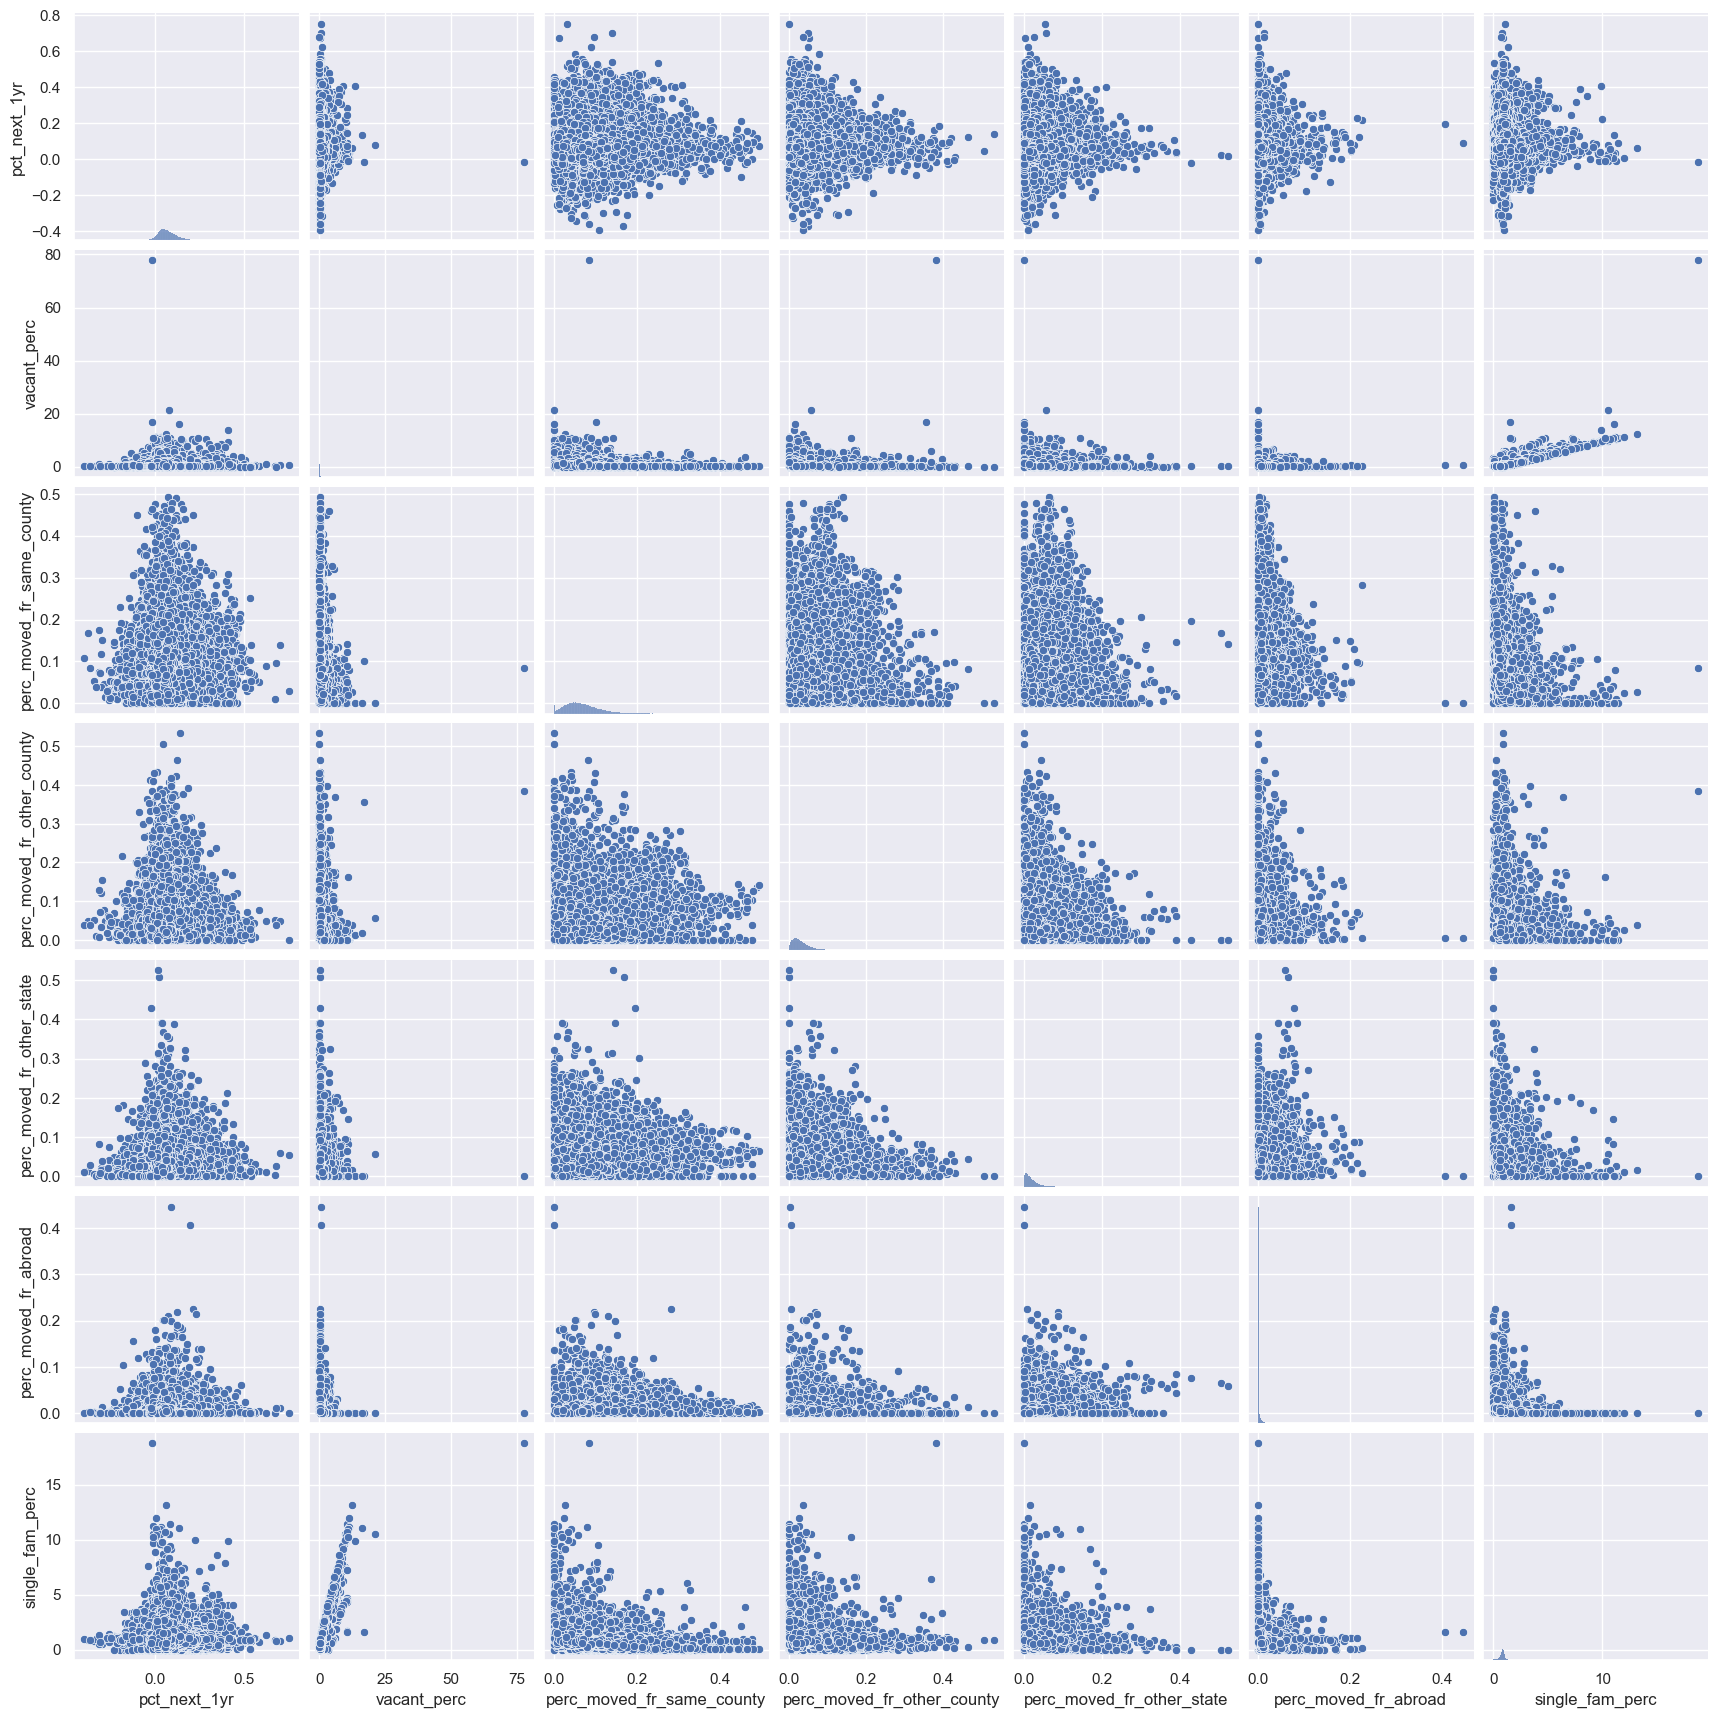

In [54]:
sns.set()
sns.pairplot(dfcombo[setd], height = 2.5)
plt.show()

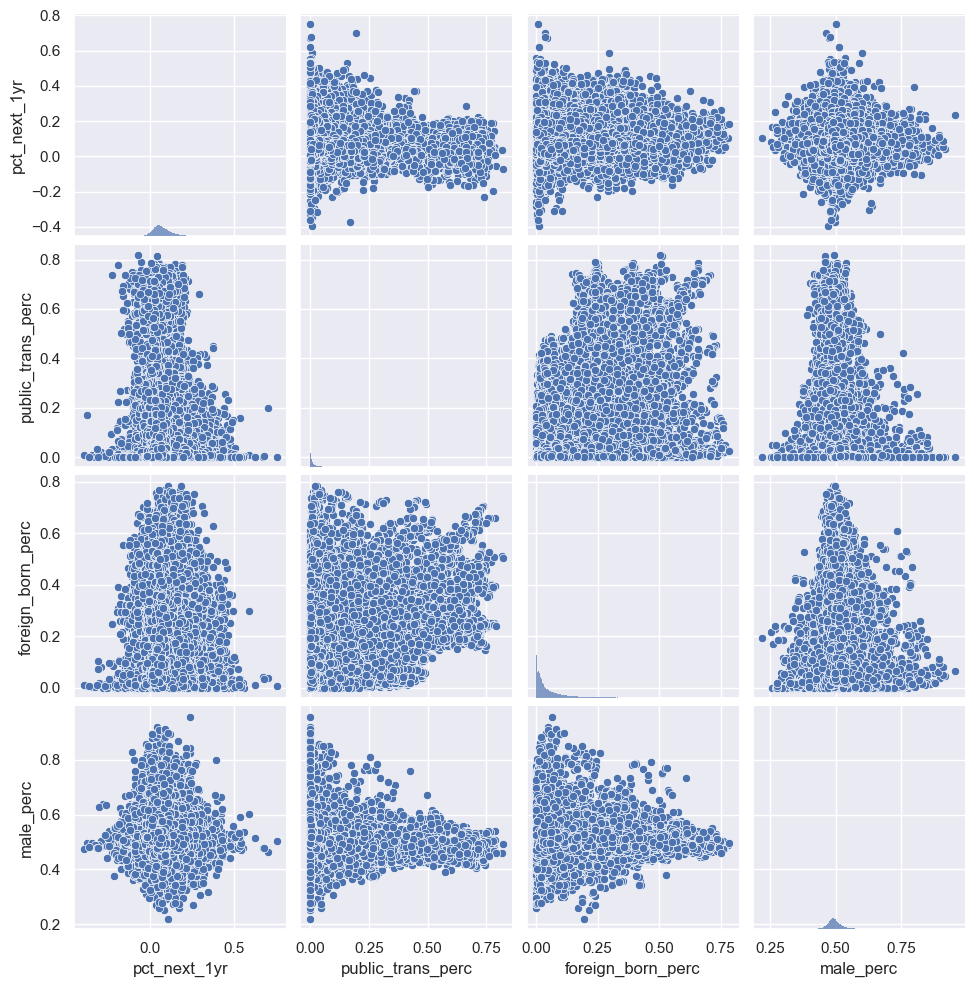

In [55]:
sns.set()
sns.pairplot(dfcombo[sete], height = 2.5)
plt.show()

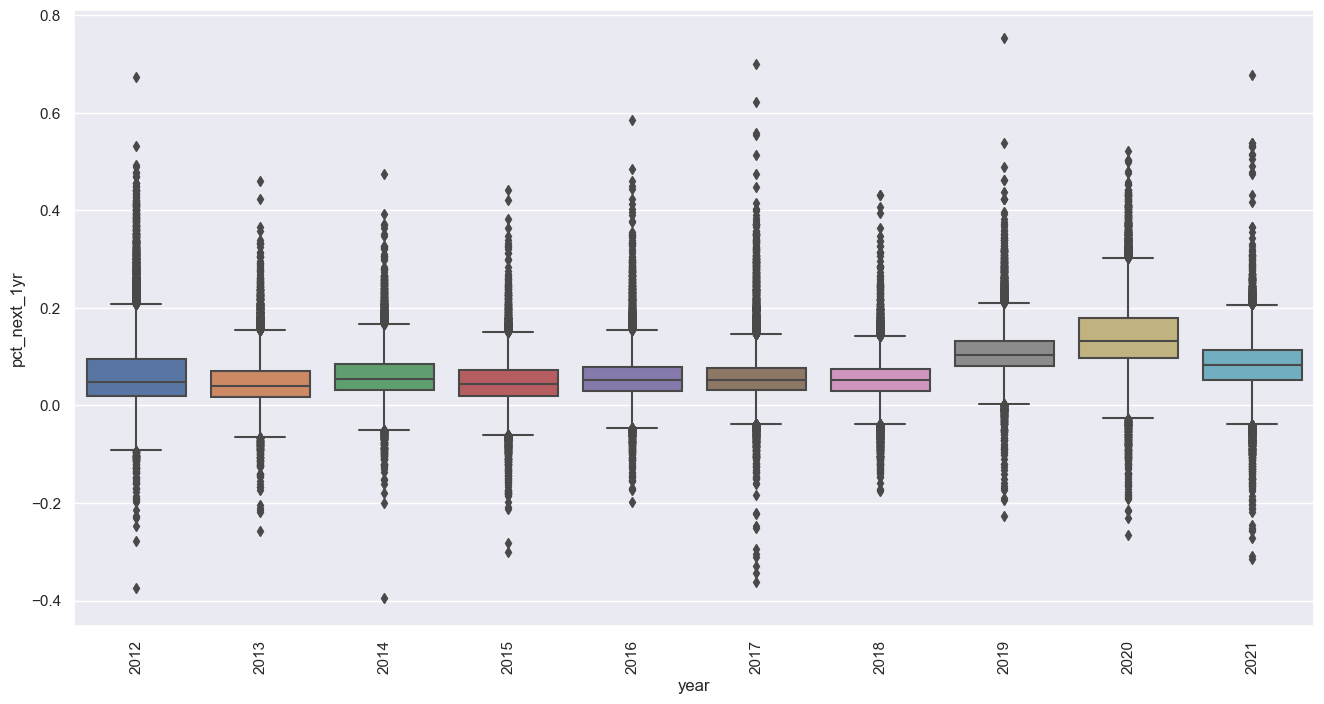

In [56]:
# look at changes of the years
data = dfcombo[['pct_next_1yr','year']]
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='year', y='pct_next_1yr', data=data)
# fig.axis(ymin=-1, ymax=1);
plt.xticks(rotation=90);




2019, 2020, and 2021 seem to be abormal. These correspond to COVID years (where 2019 represents price changes between Dec 2019 and Dec 2020) 